# Predicting Thyroid Cancer Recurrence - EDA

## The dataset

This dataset was collated as part of the study completed by Borzooei et al. (2023) to explore the possibility to training machine learning models to predict the likelihood of recurrence of well-differentiated thyroid cancer. 383 patients were a part of the study and were observed for 10 years within a period of 15 years.

Below are the columns included in the dataset and what they represent:

- Age: Patient's age.
- Gender: Patient's gender.
- Smoking: Smoking status (binary).
- Hx Smoking: History of smoking (binary).
- Hx Radiotherapy: History of radiotherapy (binary).
- Thyroid Function: Thyroid function details.
- Physical Examination: Results of physical examination.
- Adenopathy: Presence of adenopathy (binary).
- Pathology: Pathology details.
- Focality: Focality information.
- Risk: Risk assessment.
- T, N, M, Stage: Cancer staging attributes.
- Response: Response details.
- Recurred: Dependent variable indicating recurrence (binary).

## 1. Imports and Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
file_path = "../data/raw/Thyroid_Diff.csv"
df = pd.read_csv(file_path)

## 2. Initial Exploration

In [3]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [4]:
df.info()

#TODO: Update spelling of "Hx Radiotherapy" column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

There are no missing values and all bar Age are categorical features. Encoding will be required to handle the categorical features. Exploration of feature seection techniques may be required as following encoding there will be a lot of features compared to the number of observations present in the dataset.

In [5]:
df.describe()

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


The average patient age is approximately 41, with the youngest being 15 and oldest being 82. Median age is 37, which is relatively close to the mean. 

Question: Is age the age of the patient at the start of observation? _Age refers to age at diagnosis (see reference article)_

In [6]:
df.shape

(383, 17)

In [7]:
df.duplicated().sum()

19

It appears there are duplicates, however as there is many categorical features, I believe they are false duplicates (patients that fall into identical categories).

> How should this scenario be handled? My gut is to keep them as we don't have many observations to start with. (see DSTA for row independence to explain why we should drop duplicates.)

In [8]:
df.nunique()

Age                     65
Gender                   2
Smoking                  2
Hx Smoking               2
Hx Radiothreapy          2
Thyroid Function         5
Physical Examination     5
Adenopathy               6
Pathology                4
Focality                 2
Risk                     3
T                        7
N                        3
M                        2
Stage                    5
Response                 4
Recurred                 2
dtype: int64

In [9]:
# What are the categories in each feature
cat_features = df.drop(['Recurred', 'Age'], axis=1)
columns = cat_features.columns

for col in columns:
    print(f"Categories in {col}: {cat_features[col].unique()}")

Categories in Gender: ['F' 'M']
Categories in Smoking: ['No' 'Yes']
Categories in Hx Smoking: ['No' 'Yes']
Categories in Hx Radiothreapy: ['No' 'Yes']
Categories in Thyroid Function: ['Euthyroid' 'Clinical Hyperthyroidism' 'Clinical Hypothyroidism'
 'Subclinical Hyperthyroidism' 'Subclinical Hypothyroidism']
Categories in Physical Examination: ['Single nodular goiter-left' 'Multinodular goiter'
 'Single nodular goiter-right' 'Normal' 'Diffuse goiter']
Categories in Adenopathy: ['No' 'Right' 'Extensive' 'Left' 'Bilateral' 'Posterior']
Categories in Pathology: ['Micropapillary' 'Papillary' 'Follicular' 'Hurthel cell']
Categories in Focality: ['Uni-Focal' 'Multi-Focal']
Categories in Risk: ['Low' 'Intermediate' 'High']
Categories in T: ['T1a' 'T1b' 'T2' 'T3a' 'T3b' 'T4a' 'T4b']
Categories in N: ['N0' 'N1b' 'N1a']
Categories in M: ['M0' 'M1']
Categories in Stage: ['I' 'II' 'IVB' 'III' 'IVA']
Categories in Response: ['Indeterminate' 'Excellent' 'Structural Incomplete'
 'Biochemical Incomple

## 3. Univariate Analysis

In this section the distribution of the features will be explored.

In [10]:
def plot_categorical_feature(feature_name: str, explode: list):
    """Plots Count plot and pie chart

    Args:
        feature_name (str): This should correspond to the feature column name to be explored.
        explode (list): This is a list of len(number of feature categories) which specifies the fraction of the radius with which to offset each wedge.
    """
    f,ax=plt.subplots(1,2,figsize=(20,10))
    sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)


    for container in ax[0].containers:
        ax[0].bar_label(container,color='black',size=20)
        ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
    
    plt.pie(x=df[feature_name].value_counts(),labels=df[feature_name].unique(),explode=explode,autopct='%1.1f%%',shadow=True)
    plt.show()

#### Age distribution

Plot a historgram to see where the best splits for age would be when we discretise that feature.

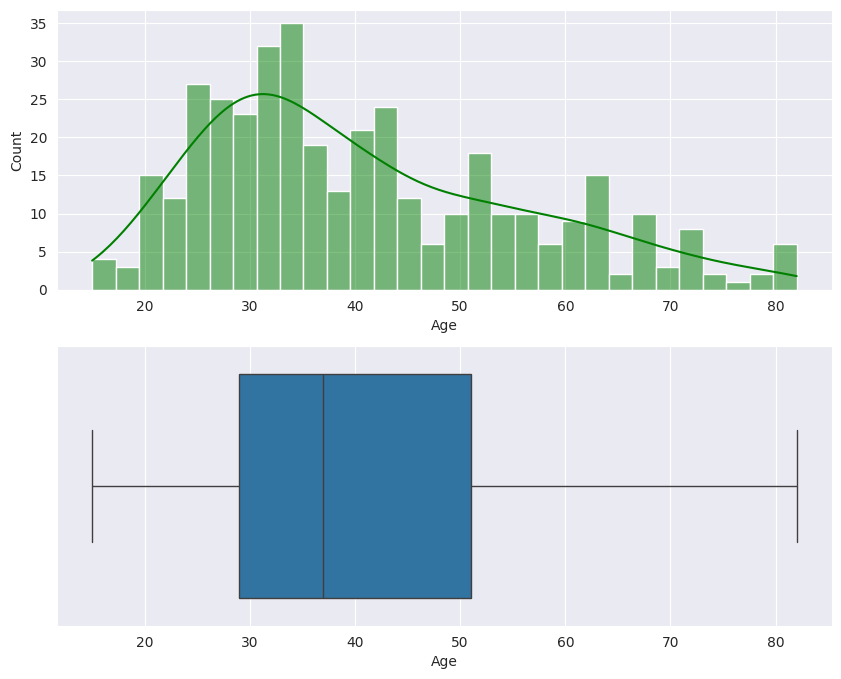

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(211)
sns.histplot(data=df,x='Age',bins=30,kde=True,color='g')
plt.subplot(212)
sns.boxplot(data=df, x='Age')
plt.show()

### Gender distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)


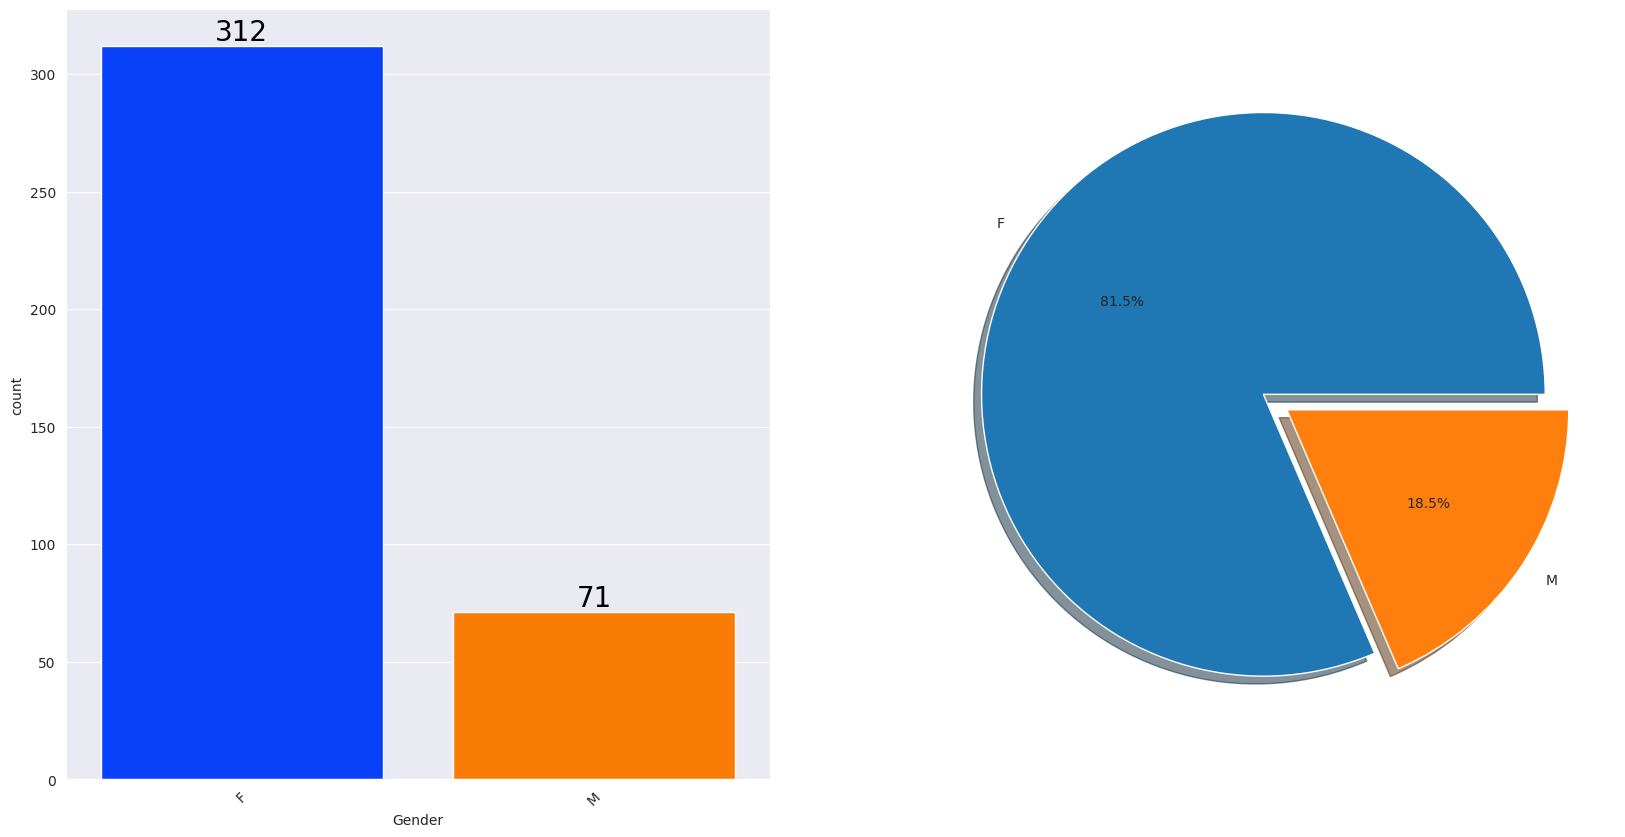

In [12]:
plot_categorical_feature("Gender", [0,0.1])

#### Insights

The dataset predominantly comprises female patients (81.5%) compared to male patients (18.5%). Given thyroid cancer's higher prevalence in females, this distribution aligns with existing epidemiological trends and emphasizes the importance of gender-specific considerations in recurrence prediction models.

### Smoking distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)


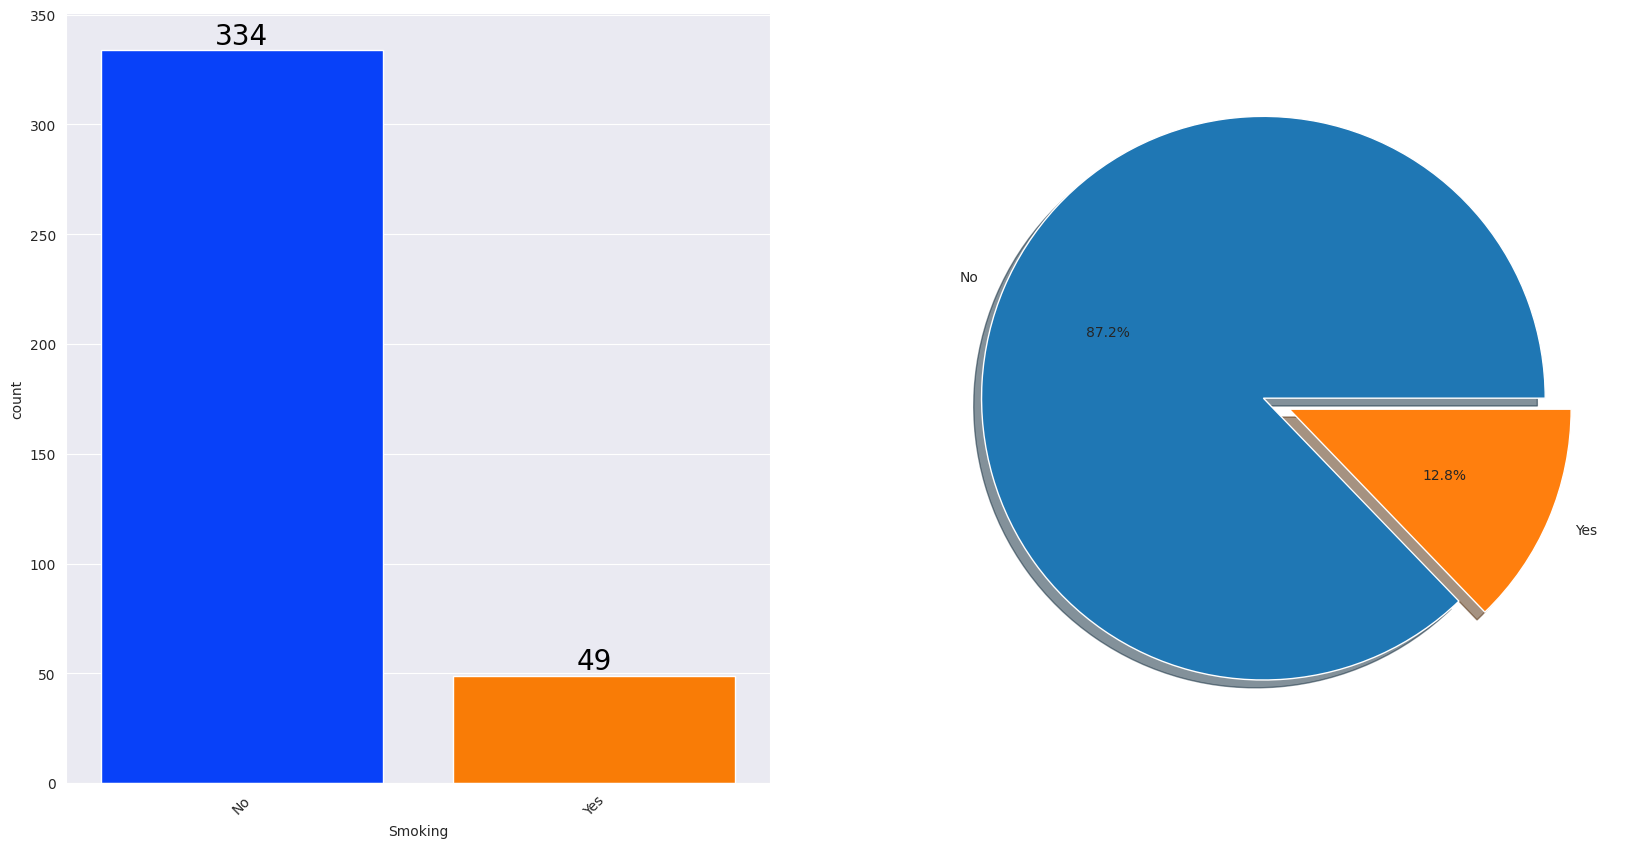

In [13]:
plot_categorical_feature("Smoking", [0,0.1])

#### Insights


The majority of patients in the study are nonsmokers (87.2%), while a smaller proportion are smokers (12.8%). This suggests that smoking might not be a predominant risk factor for thyroid cancer recurrence in this cohort, potentially prompting further investigation into other contributing factors.

### Hx Smoking Distribution

> Are these patients that have smoked in the past but currently are not smokers? (excluding those who answered yes to the previous question?)

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)


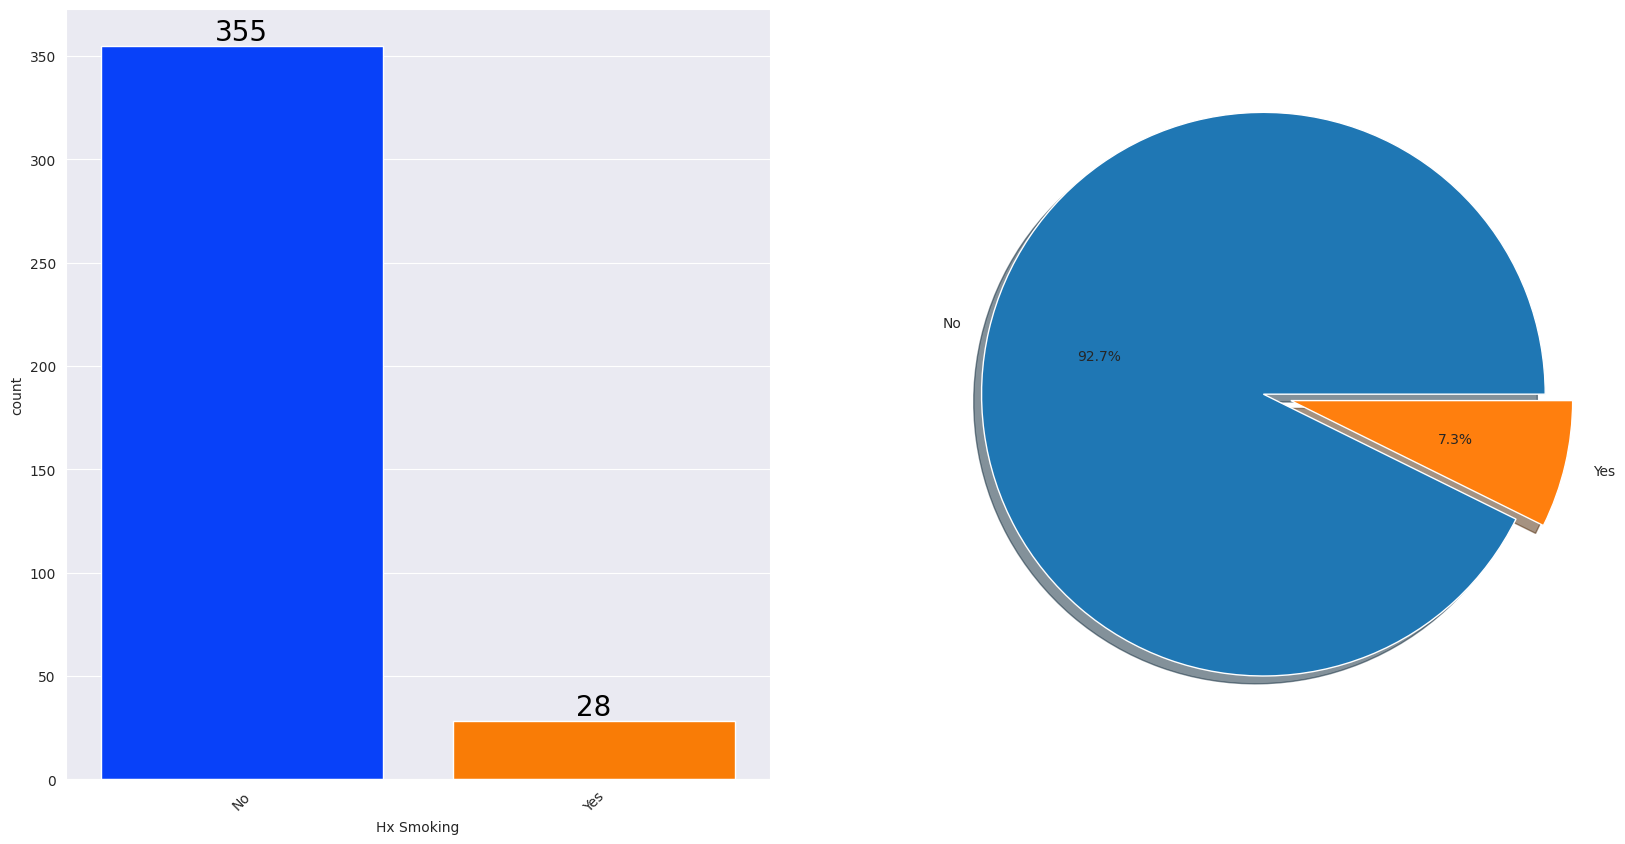

In [14]:
plot_categorical_feature("Hx Smoking", [0,0.1])

#### Insights

The majority of patients in the dataset have no history of smoking (92.7%), while a small portion have a history of smoking (7.3%). This suggests that a history of smoking might not be a prevalent factor influencing thyroid cancer recurrence in this cohort, warranting further investigation into other potential predictors.

### Hx Radiotherapy Distribution


/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)


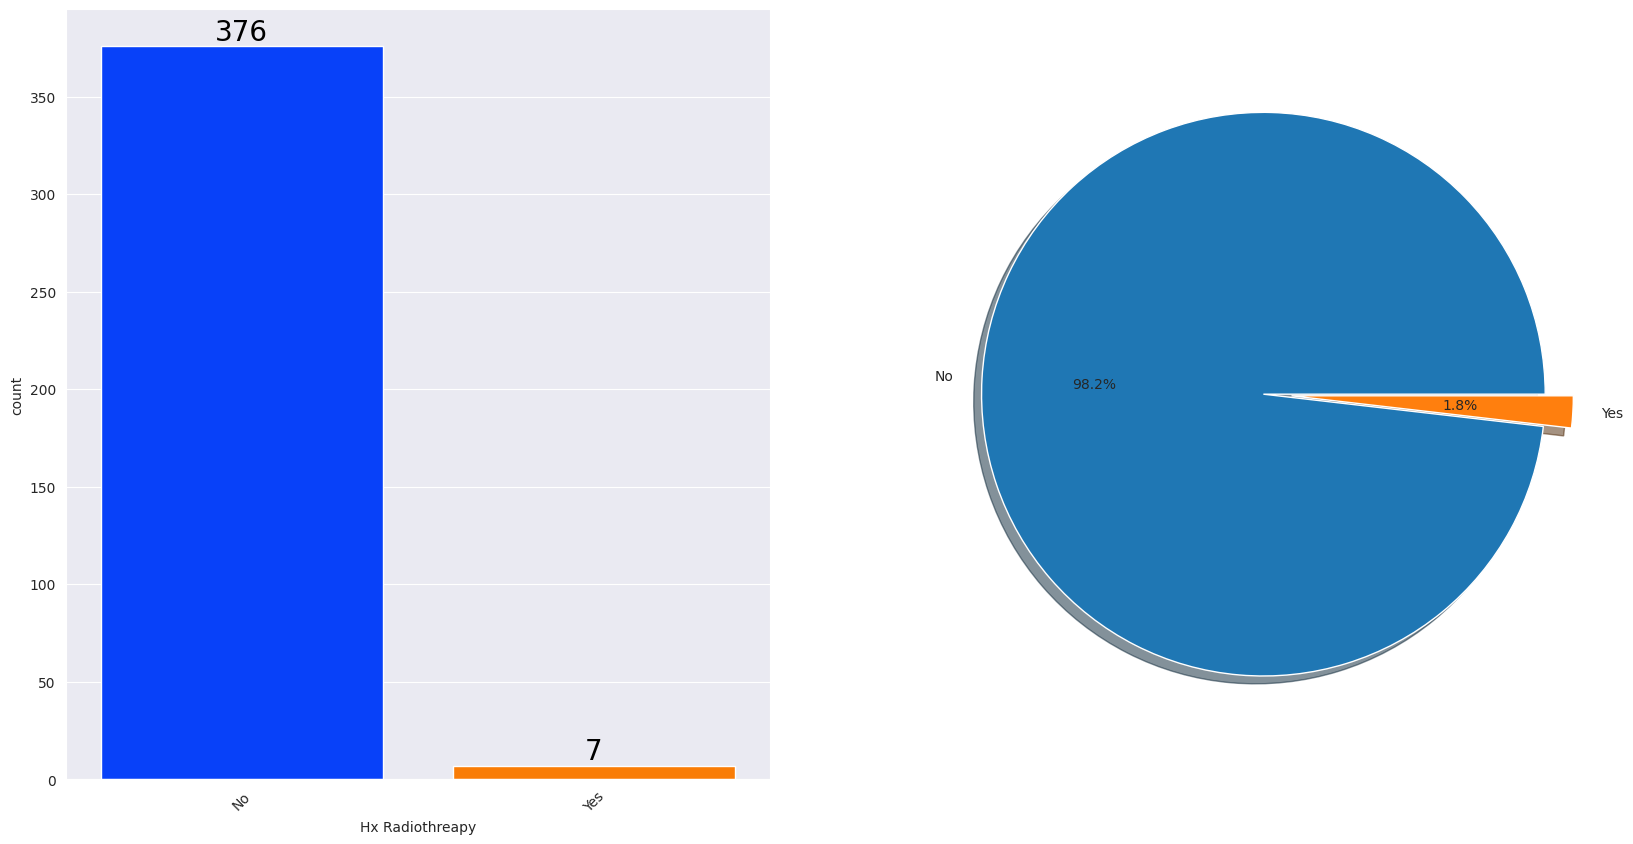

In [15]:
plot_categorical_feature("Hx Radiothreapy", [0,0.1])

#### Insights

The vast majority of patients (98.2%) have no history of radiotherapy, while only a small fraction (1.8%) have undergone radiotherapy. This suggests that radiotherapy might not be a prevalent treatment option for this cohort, potentially indicating other primary treatment modalities or early-stage disease presentation.

### Thyroid Function Distribution



/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

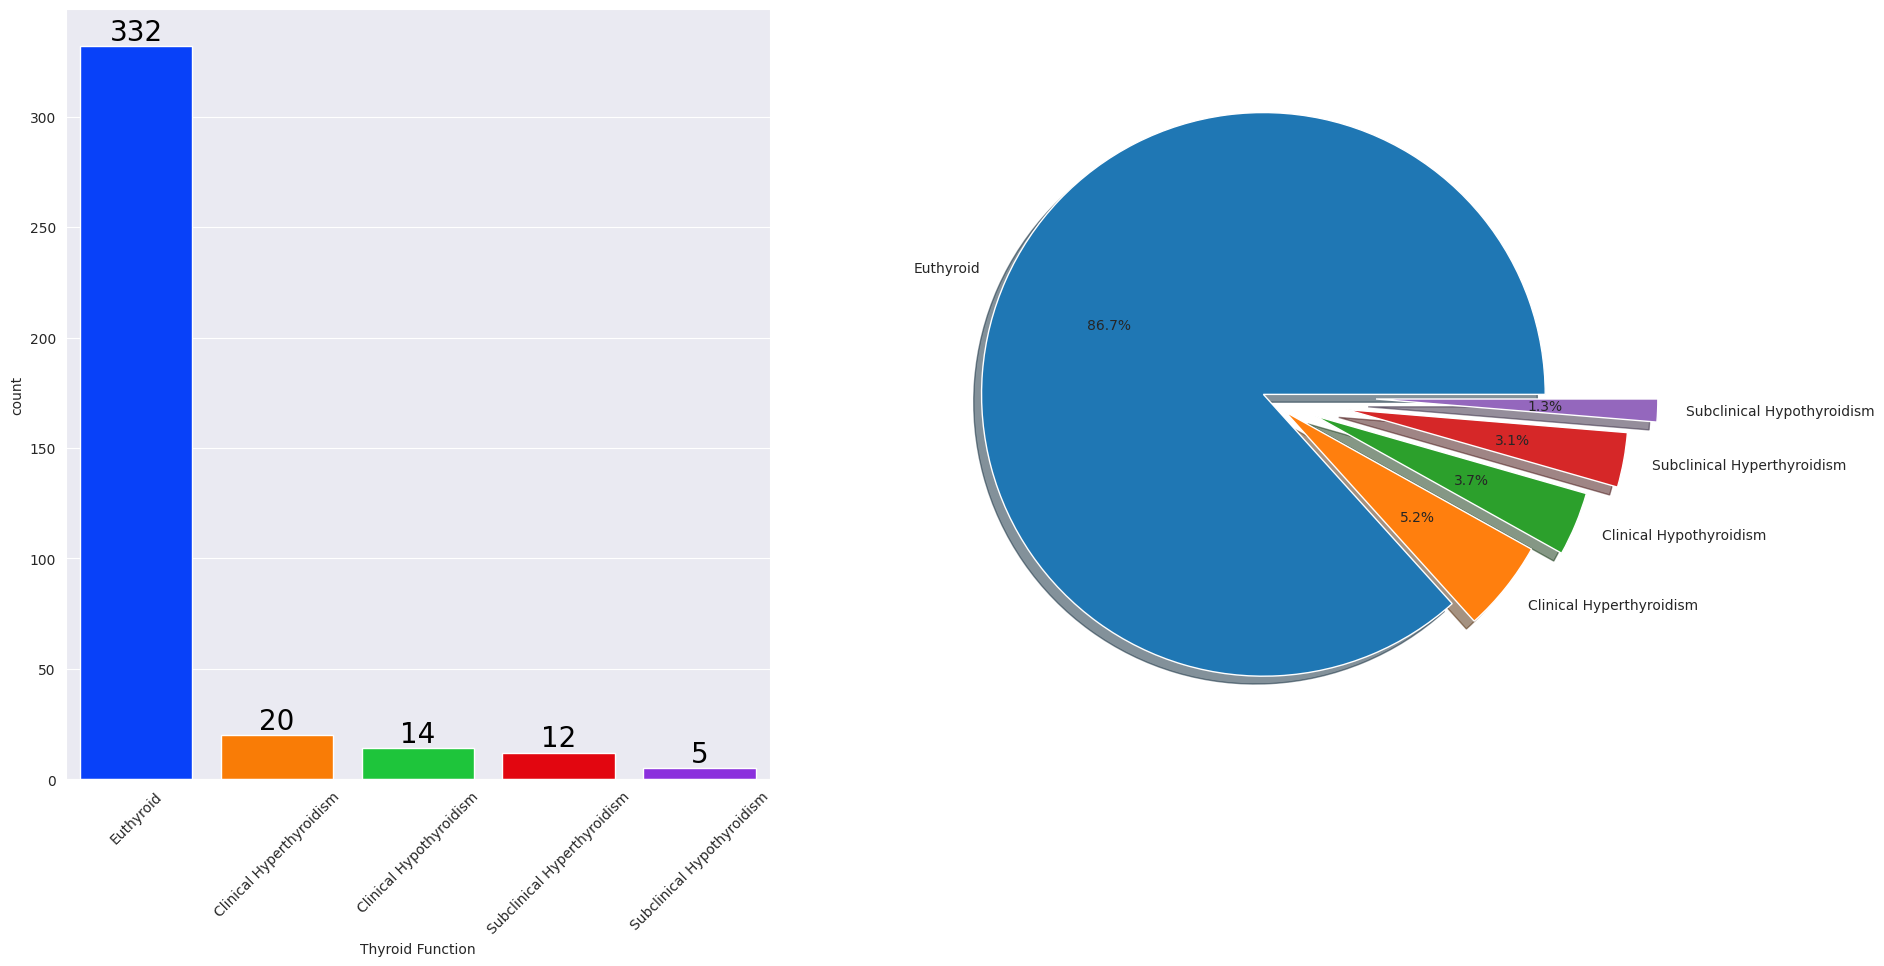

In [16]:
plot_categorical_feature("Thyroid Function", [0, 0.1, 0.2, 0.3, 0.4])

### Physical Examination Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

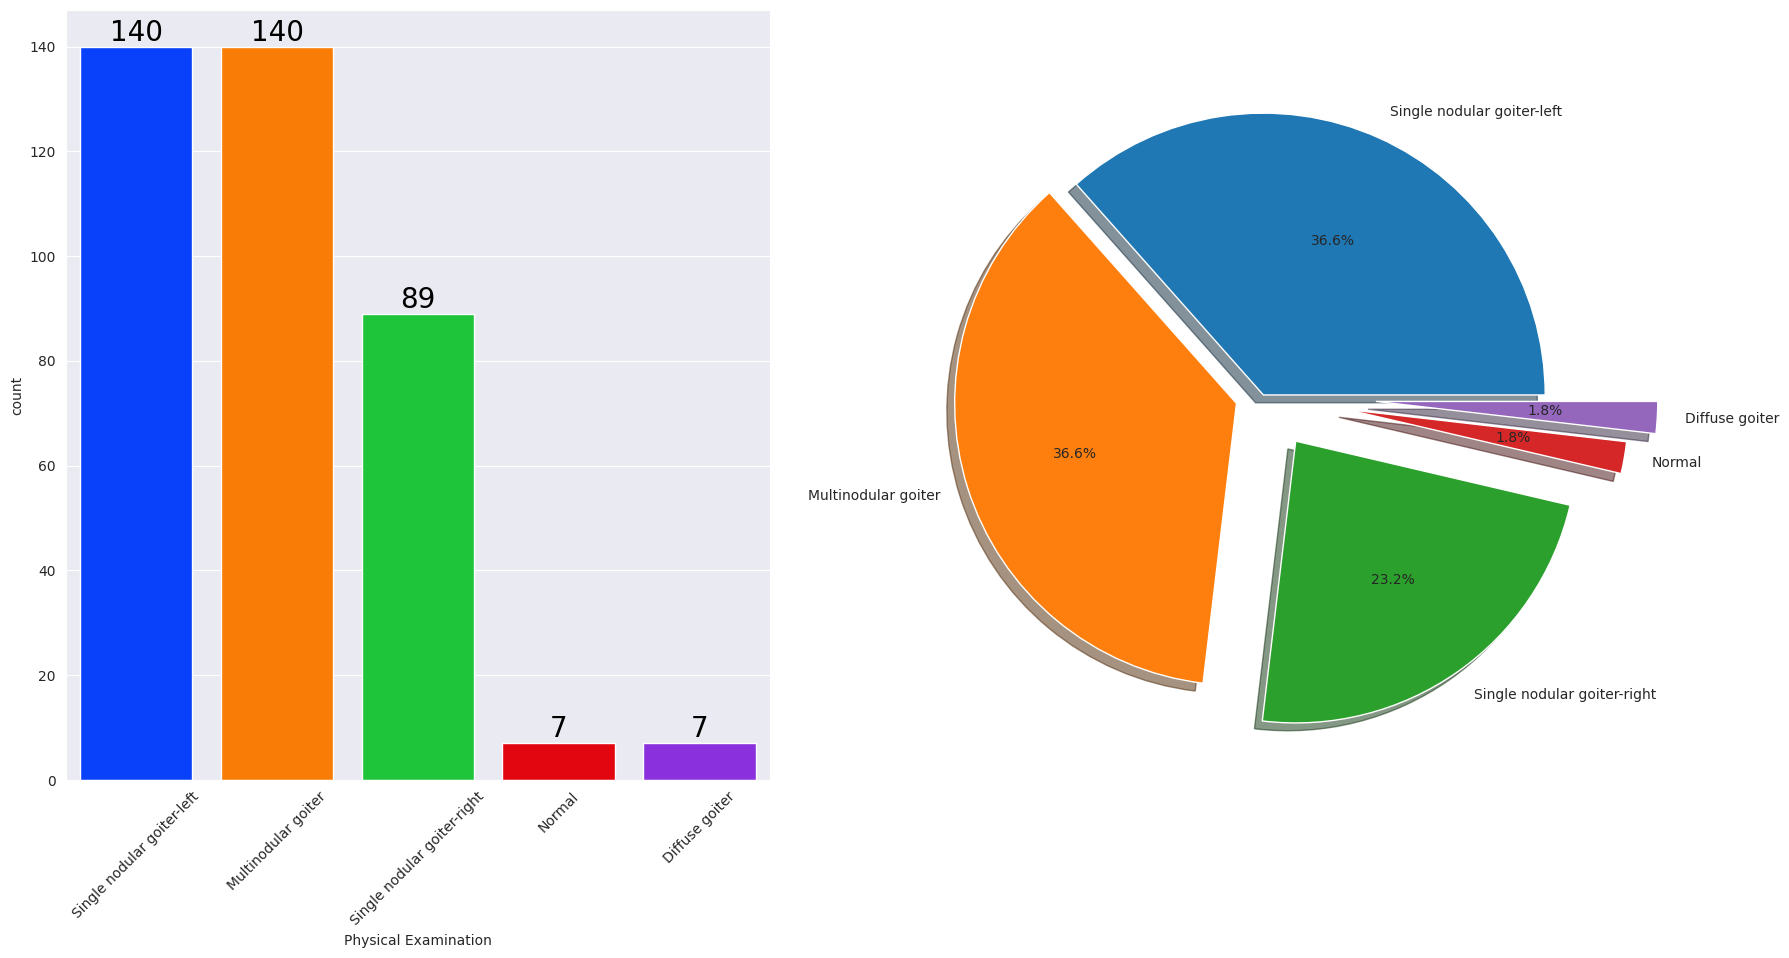

In [17]:
plot_categorical_feature("Physical Examination", [0, 0.1, 0.2, 0.3, 0.4])

#### Insights

The majority of patients exhibit euthyroid status (86.7%), indicating normal thyroid function. Clinical hyperthyroidism and hypothyroidism are less prevalent (5.2% and 3.7% respectively), with subclinical cases even rarer. This suggests thyroid function's potential impact on recurrence risk warrants further investigation, particularly in abnormal cases.

### Adenopathy Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

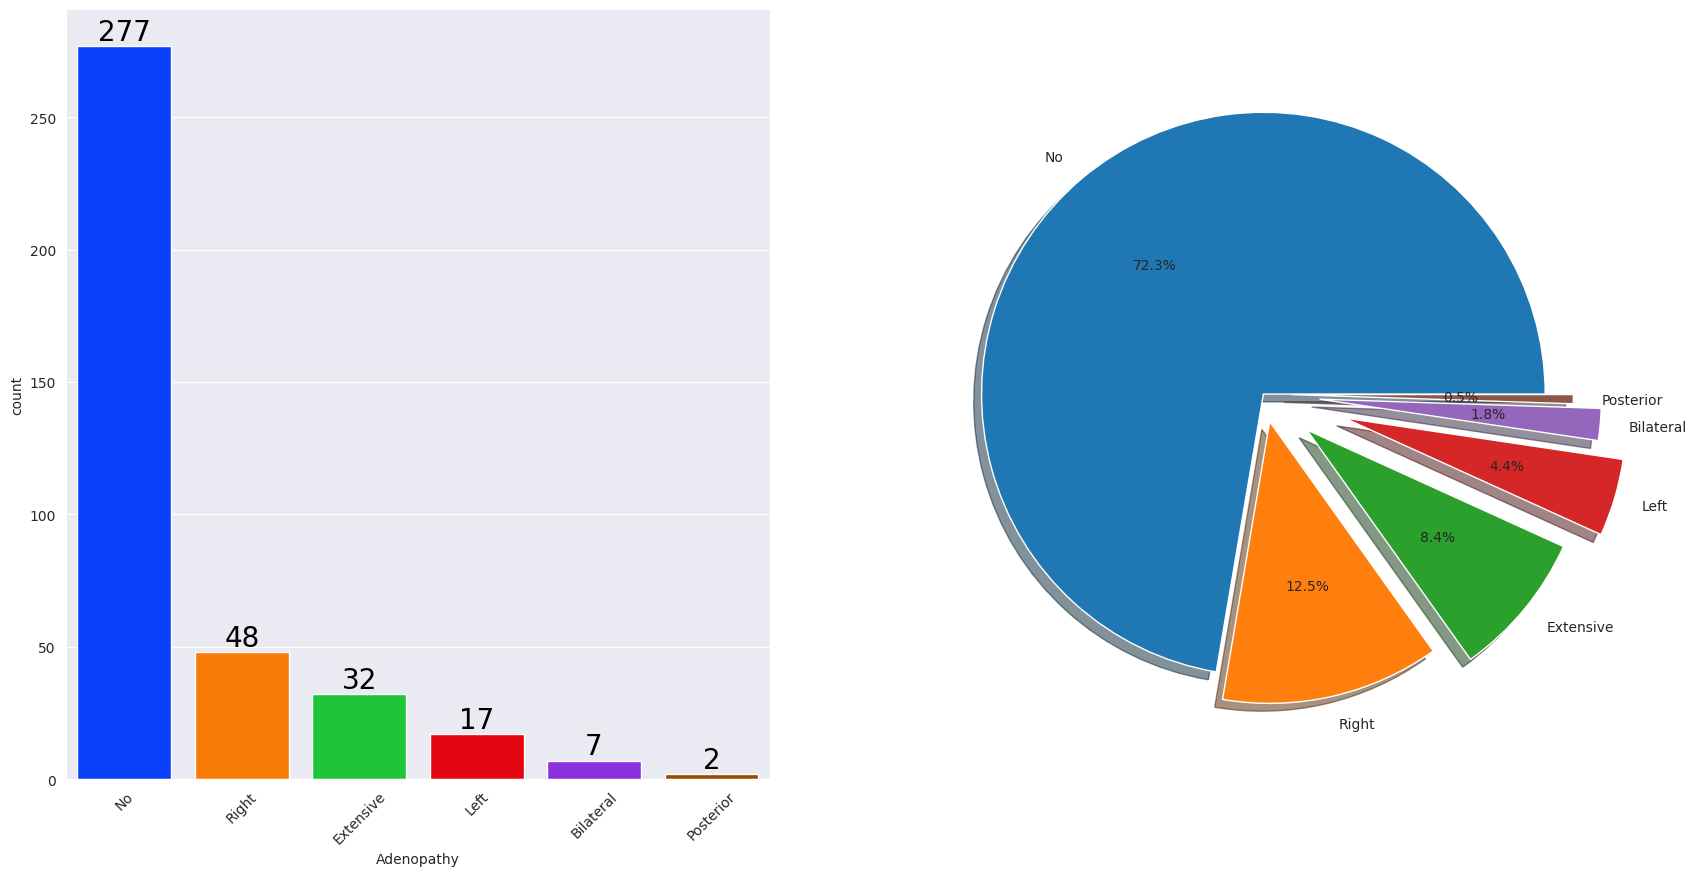

In [18]:
plot_categorical_feature("Adenopathy",[0, 0.1, 0.2, 0.3, 0.2, 0.1])

#### Insights

The majority of patients exhibit no adenopathy (72.3%). Among those with adenopathy, it tends to be asymmetric, with right-sided (12.5%) slightly more common than left-sided (4.4%) or bilateral (1.8%) involvement. Extensive and posterior adenopathy are less frequent (8.4% and 0.5% respectively).

### Pathology Distribution



/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

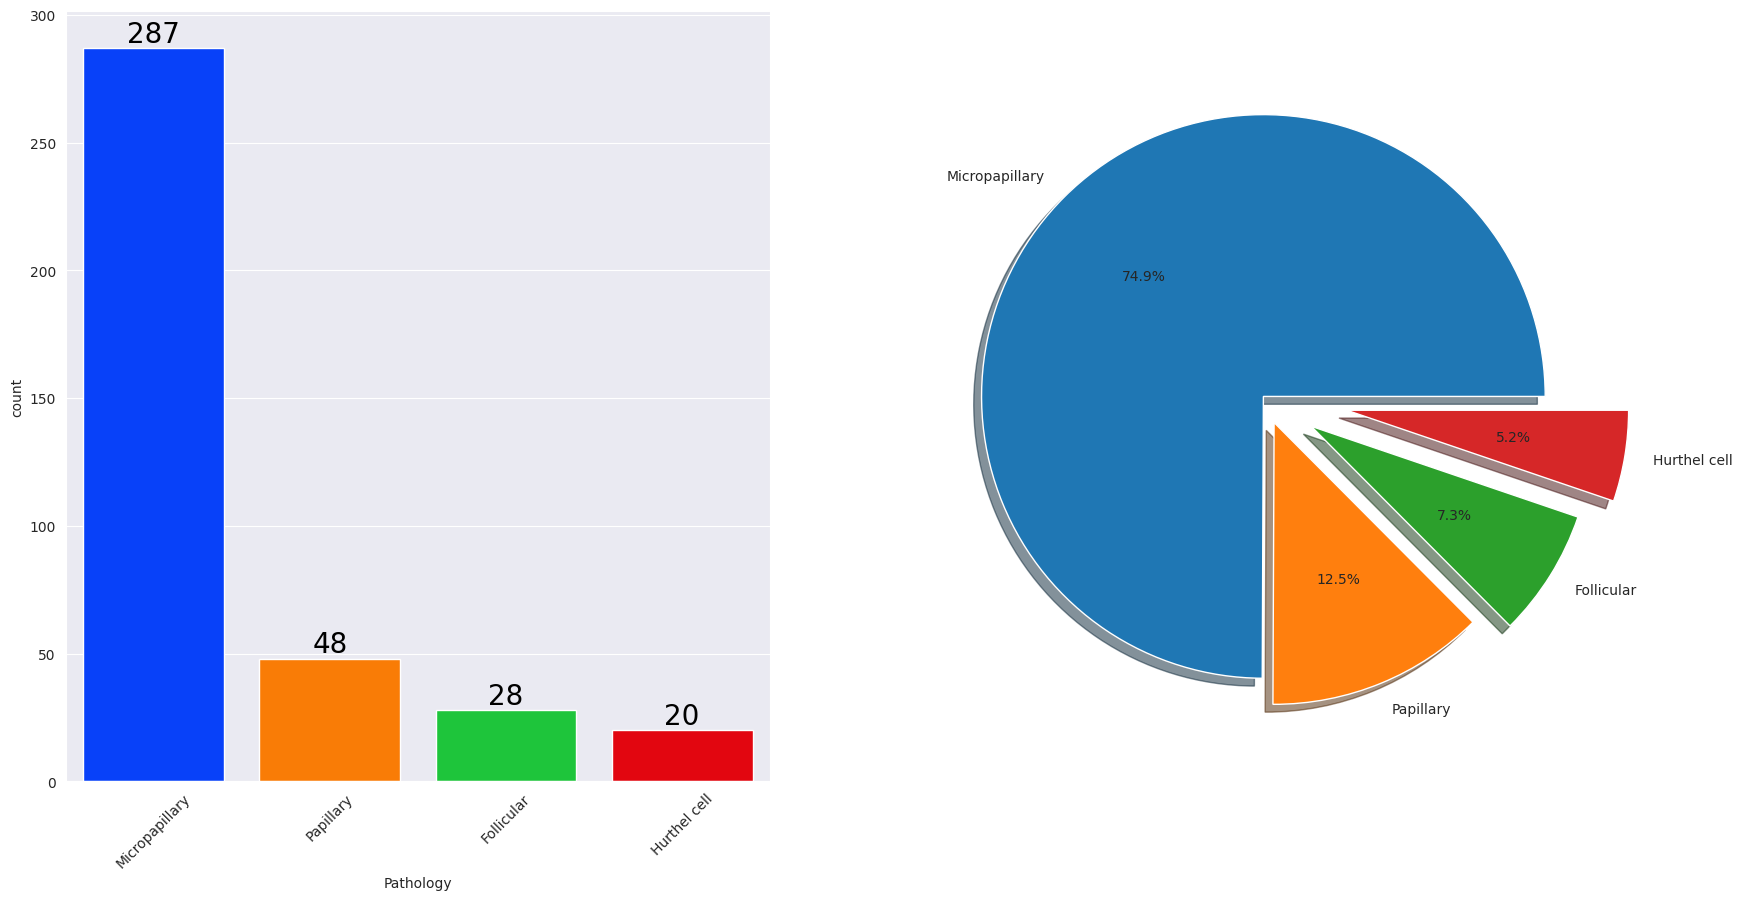

In [19]:
plot_categorical_feature("Pathology",[0, 0.1, 0.2, 0.3])

#### Insights

The majority of patients have micropapillary pathology (74.9%), followed by papillary (12.5%), follicular (7.3%), and Hurthel cell (5.2%) types. Micropapillary pathology is most prevalent, potentially indicating its significance as a subtype in predicting thyroid cancer recurrence compared to other types.

### Focality Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)


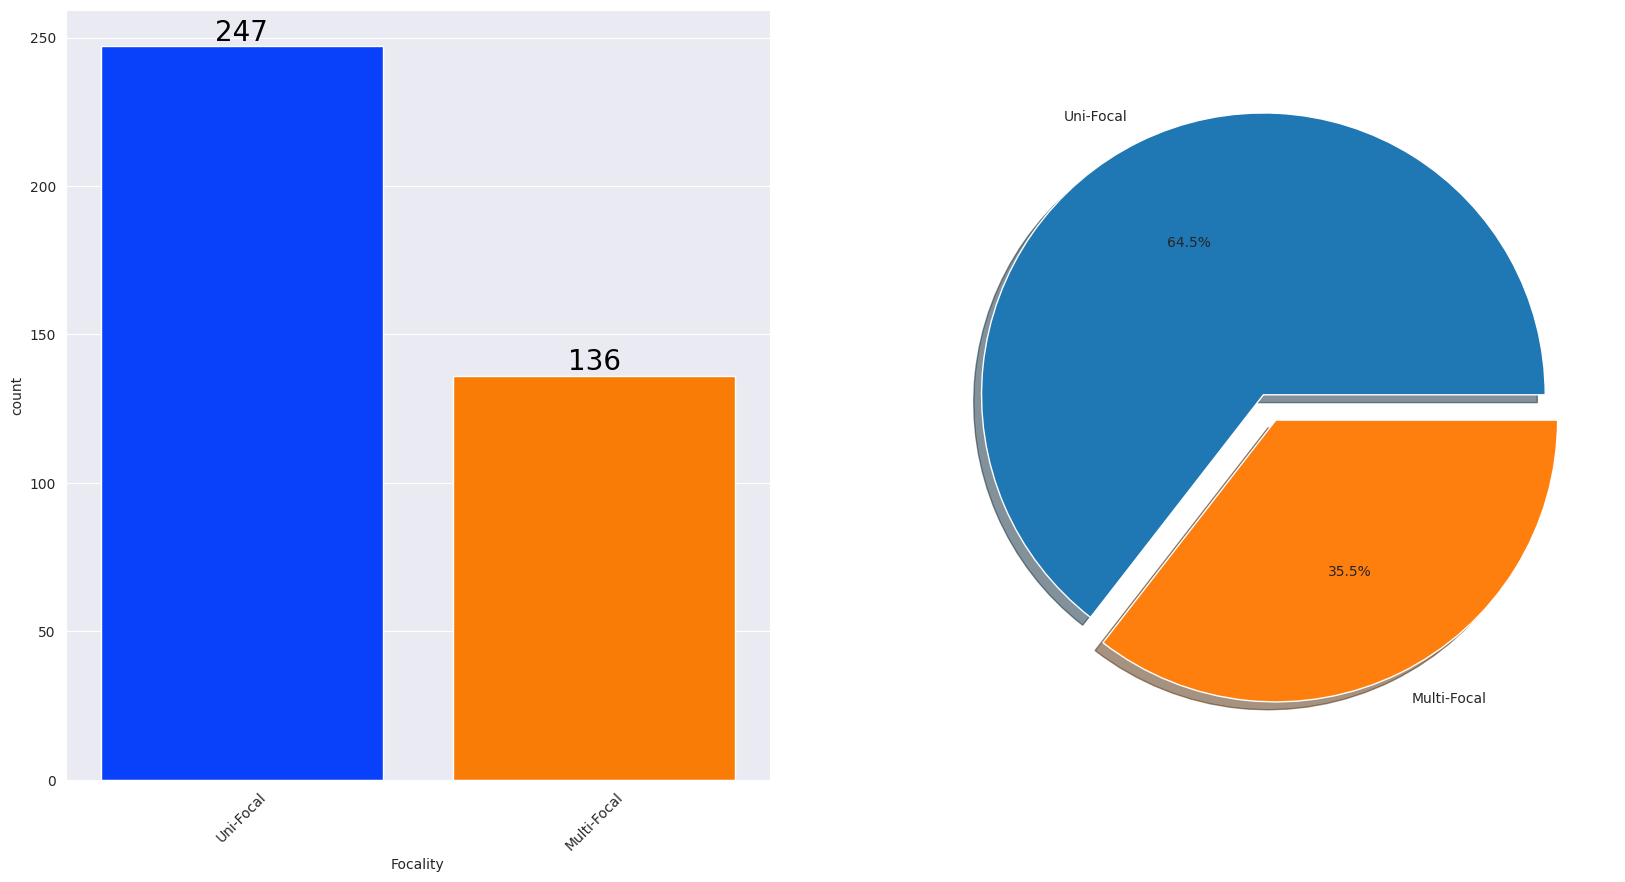

In [20]:
plot_categorical_feature("Focality",[0, 0.1,])

#### Insights

The majority of patients have unifocal thyroid cancer (64.5%), while a significant portion present with multifocal disease (35.5%). This distribution suggests that the tumor's focal pattern may influence the risk of recurrence, indicating a need to consider tumor multifocality in recurrence prediction models.

### Risk Distribution



/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

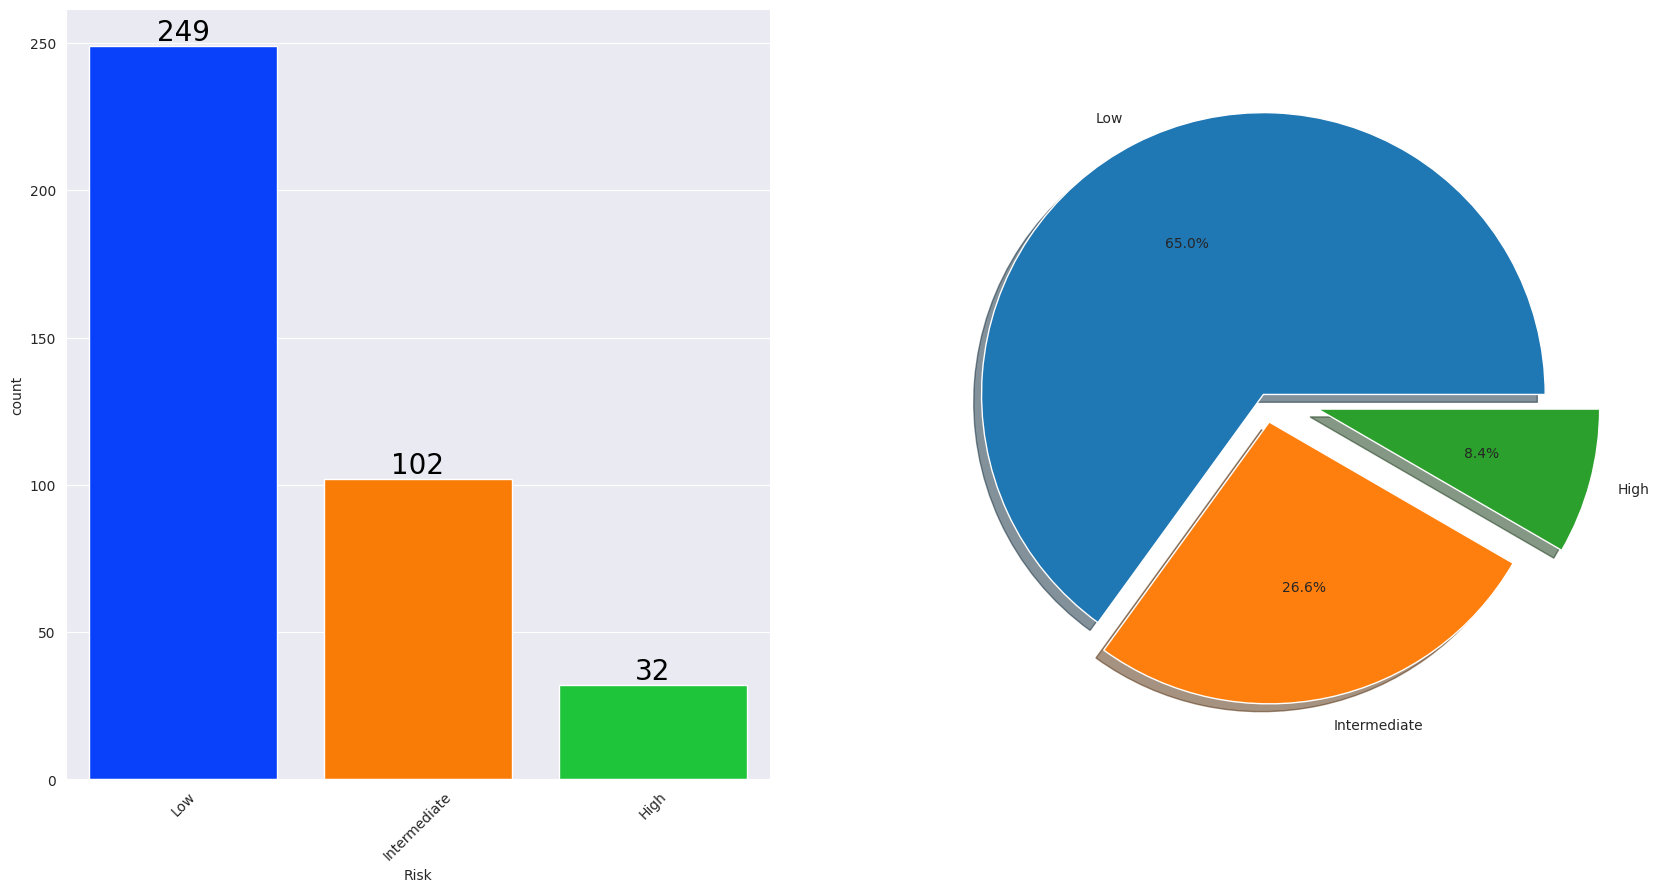

In [21]:
plot_categorical_feature("Risk",[0, 0.1, 0.2])

#### Insights

The majority of patients have a low risk of thyroid cancer recurrence (65%), while a significant portion fall into the intermediate risk category (26.6%). Fewer patients are classified as high risk (8.4%). This stratification suggests the importance of assessing recurrence risk for tailored management strategies.

### T Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

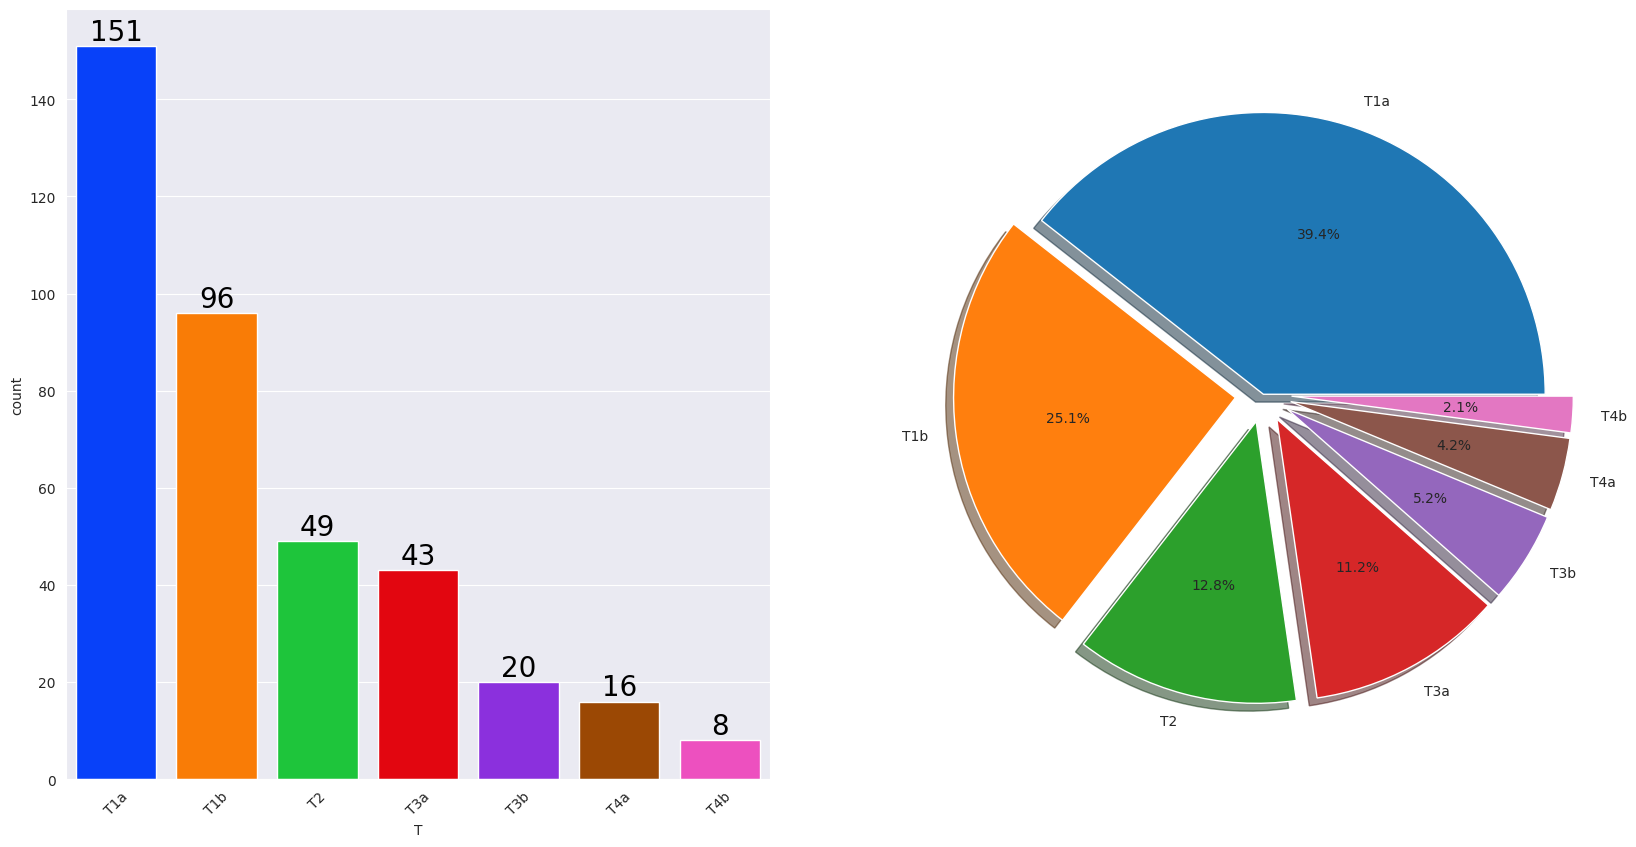

In [22]:
plot_categorical_feature("T",[0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

#### Insights


The majority of patients have early-stage thyroid cancer, with T1a being the most common (39.4%), followed by T1b (25.1%). T2 and T3 stages represent a smaller proportion, indicating that early-stage tumors dominate the cohort, potentially influencing the risk of recurrence

### N Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

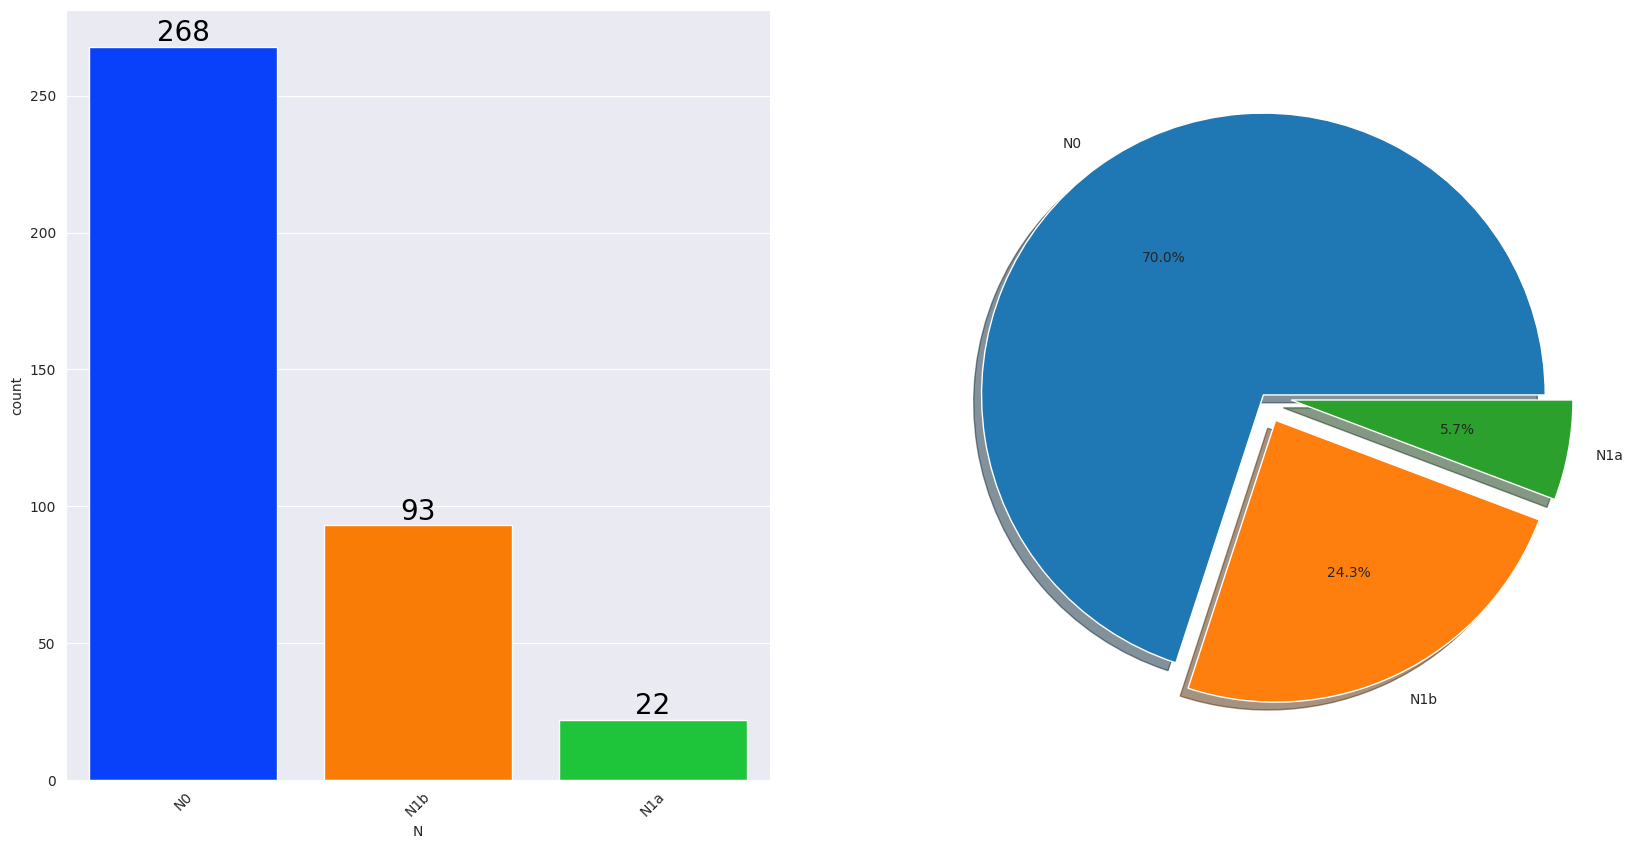

In [23]:
plot_categorical_feature("N", [0, 0.1, 0.1])

#### Insights

The majority of patients are staged as N0 (70.0%), indicating absence of regional lymph node metastasis. However, a notable proportion show metastasis to different levels of lymph nodes: N1b (24.3%) and N1a (5.7%). This highlights the importance of lymph node involvement in predicting thyroid cancer recurrence.

### M Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)


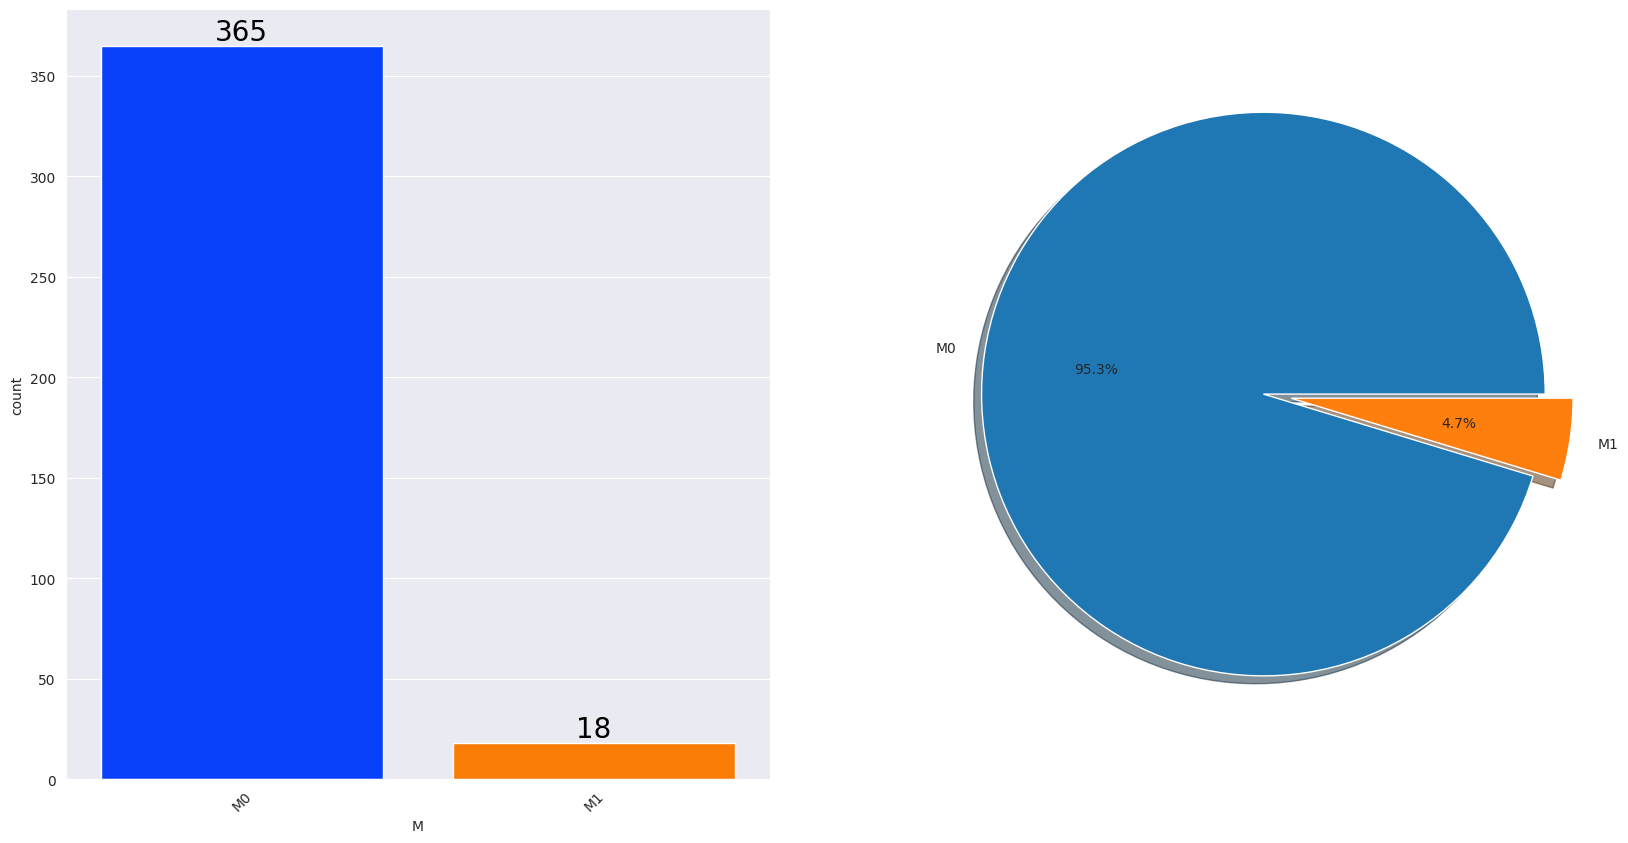

In [24]:
plot_categorical_feature("M", [0, 0.1, ])

#### Insights

The majority of patients are categorized as M0 (95.3%), indicating absence of distant metastasis. A small proportion are classified as M1 (4.7%), suggesting distant metastasis presence. The low percentage of M1 cases underscores the importance of monitoring for distant metastases in thyroid cancer recurrence prediction models.

### Stage Distribution

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

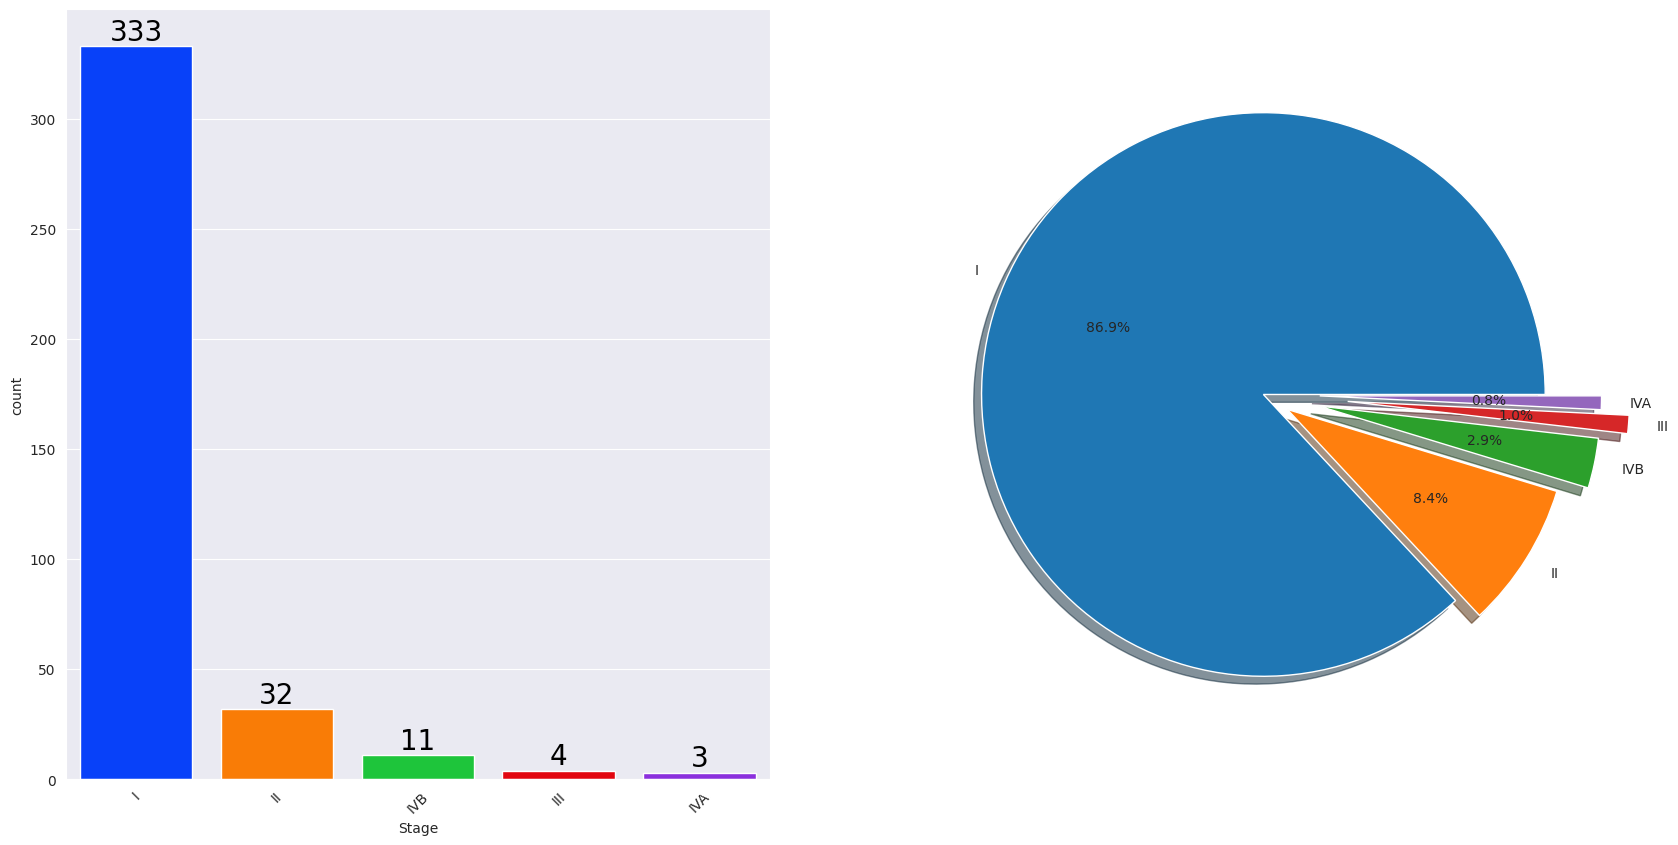

In [25]:
plot_categorical_feature("Stage", [0, 0.1, 0.2, 0.3, 0.2])

#### Insights

The majority of patients are at Stage I (86.9%), indicating an early cancer stage. This suggests that the majority of patients in the study have a favorable prognosis regarding recurrence. However, there are still notable proportions in higher stages, emphasizing the need for personalized surveillance and management strategies.

### Response

'Indeterminate', 'Excellent', 'Structural Incomplete', 'Biochemical Incomplete'

/tmp/ipykernel_60879/741133817.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[feature_name],data=df,palette ='bright',ax=ax[0],saturation=0.95, order=df[feature_name].value_counts().index)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=df[feature_name].unique(), rotation=45)
/tmp/ipykernel_60879/741133817.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].

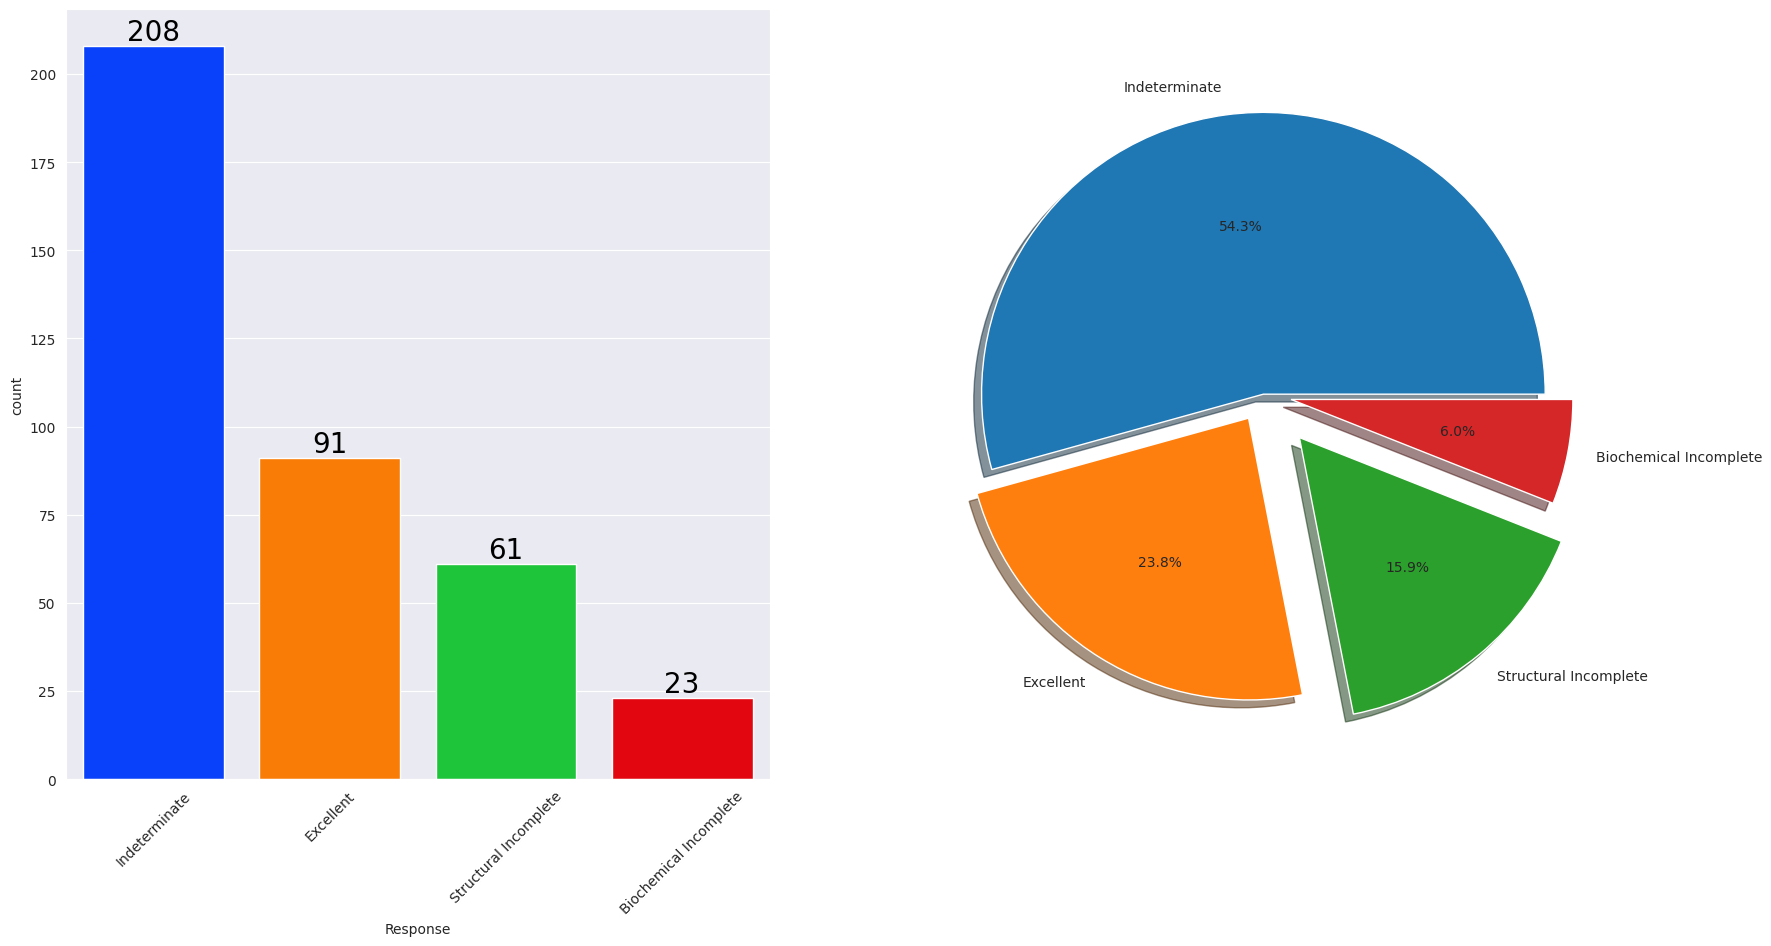

In [26]:
plot_categorical_feature("Response", [0, 0.1, 0.2, 0.1])

#### Insights

The majority of patients have an indeterminate response regarding recurrence (54.3%), followed by excellent (23.8%), structural incomplete (15.9%), and biochemical incomplete (6.0%) responses. This highlights the challenge in predicting recurrence, indicating the importance of accurate risk assessment for appropriate management strategies.

In [27]:
# Created a dictionary of all columns class distribution
columns = df.columns
feature_distributions = {}
for col in columns:
    distribution = df.groupby(col).size()
    feature_distributions[col] = distribution
    

## Exploring Class Distribution

In [28]:
# Target class distribution
target_distribution = df.groupby('Recurred').size()
target_distribution

Recurred
No     275
Yes    108
dtype: int64

We can see that there is more than half of the observations with the class Yes compared with No, so our dataset is imbalanced. This will have to be considered when preparing for modelling.

## 4. Bivariate Analysis

Now we will explore the strength of relationship between the features and the target variable.

For our numerical feature Age, we will plot a histogram with a hue to show the relationship between age and recurrence.

For our categorical features we will construct contingency tables and perform a $chi^2$ test to analyse any relationships.

### Age vs Recurred

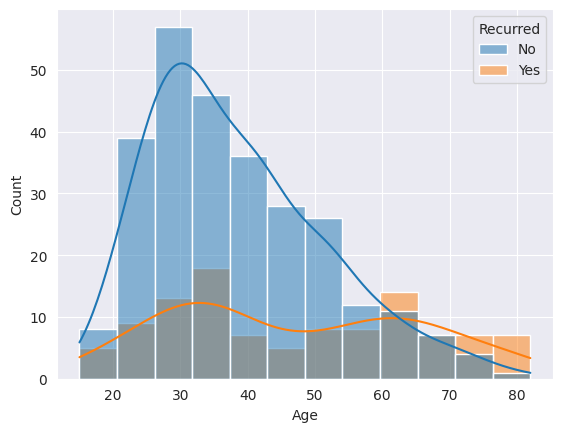

In [29]:
sns.histplot(data=df,x='Age',kde=True,hue='Recurred')
plt.show()

#### Insights

### Categorical Feature Bivariate Analysis

This analysis is formed of a contingency table and chi-squared statistics to evaluate the distribution of categorical features with respect to the target variable.

- $H_0$ = There is no difference in distribution of the feature with respect to the target variable
- $H_1$ = There is a difference in distribution of the feature with respect to the target variable

In [30]:
# import
from scipy.stats import chi2_contingency

In [31]:
def contingency_heatmap_and_chi2(feature_name: str):
    """
    Function to create a contingency table heatmap and generate chi-squared statistics for categorical feature relationship analysis.
    Args:
        feature_name (str): Name of the feature to be compared with the target variable.
    """
    cont_table = pd.crosstab(df[feature_name], df.Recurred)
    sns.heatmap(cont_table, annot=True)
    plt.title(f"{feature_name} vs Recurred")
    plt.show()
    chi2, p, dof, expected = chi2_contingency(cont_table)
    print("==================================")
    print(f"===== {feature_name} Chi2 Analysis =====")
    print("==================================")
    print(f"Chi2: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies: {expected}")
    print("==================================")
    
    if p <= 0.05:
        print("Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.")
    else:
        print("Retain the null hypothesis, there is no difference in distribution of the feature with respect to the target variable.")


### Gender and Recurred

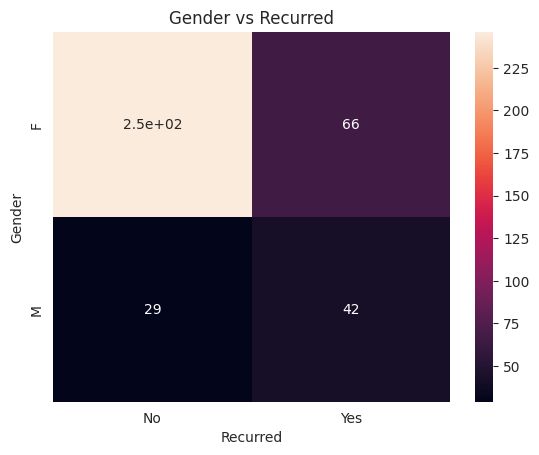

===== Gender Chi2 Analysis =====
Chi2: 39.396676469993665
P-Value: 3.4588517738589313e-10
Degrees of Freedom: 1
Expected Frequencies: [[224.02088773  87.97911227]
 [ 50.97911227  20.02088773]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [32]:
contingency_heatmap_and_chi2("Gender")

### Smoking vs Recurred

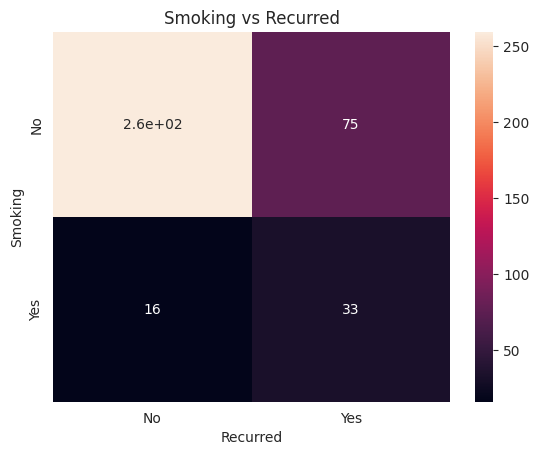

===== Smoking Chi2 Analysis =====
Chi2: 40.34407383079646
P-Value: 2.129503925882454e-10
Degrees of Freedom: 1
Expected Frequencies: [[239.81723238  94.18276762]
 [ 35.18276762  13.81723238]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [33]:
contingency_heatmap_and_chi2("Smoking")

### Hx Smoking Vs Recurred

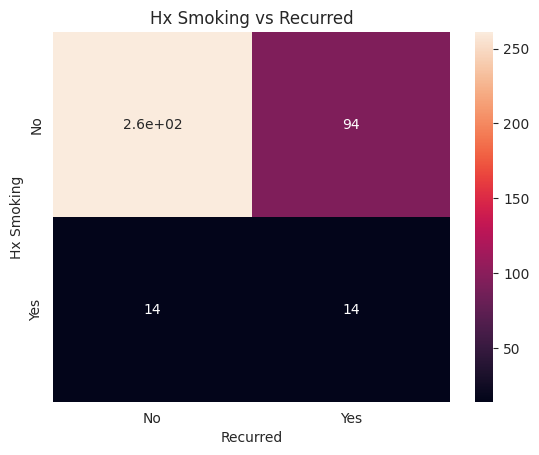

===== Hx Smoking Chi2 Analysis =====
Chi2: 5.977474414669837
P-Value: 0.014489737063609615
Degrees of Freedom: 1
Expected Frequencies: [[254.89556136 100.10443864]
 [ 20.10443864   7.89556136]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [34]:
contingency_heatmap_and_chi2("Hx Smoking")

### Hx Radiothreapy Vs Recurred

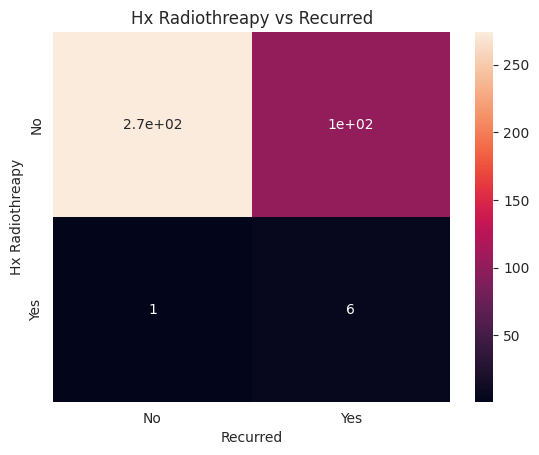

===== Hx Radiothreapy Chi2 Analysis =====
Chi2: 8.9360505479056
P-Value: 0.002795966115812055
Degrees of Freedom: 1
Expected Frequencies: [[269.97389034 106.02610966]
 [  5.02610966   1.97389034]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [35]:
contingency_heatmap_and_chi2("Hx Radiothreapy")

### Thyroid Function Vs Recurred

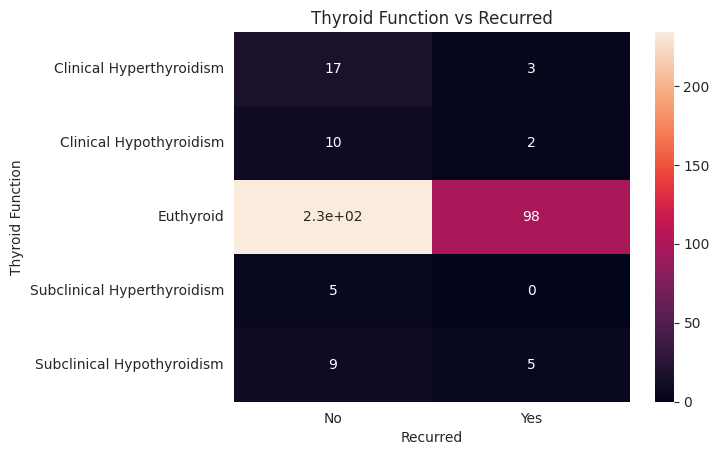

===== Thyroid Function Chi2 Analysis =====
Chi2: 5.14868693919497
P-Value: 0.27237868540391813
Degrees of Freedom: 4
Expected Frequencies: [[ 14.36031332   5.63968668]
 [  8.61618799   3.38381201]
 [238.38120104  93.61879896]
 [  3.59007833   1.40992167]
 [ 10.05221932   3.94778068]]
Retain the null hypothesis, there is no difference in distribution of the feature with respect to the target variable.


In [36]:
contingency_heatmap_and_chi2("Thyroid Function")

### Physical Examination Vs Recurred

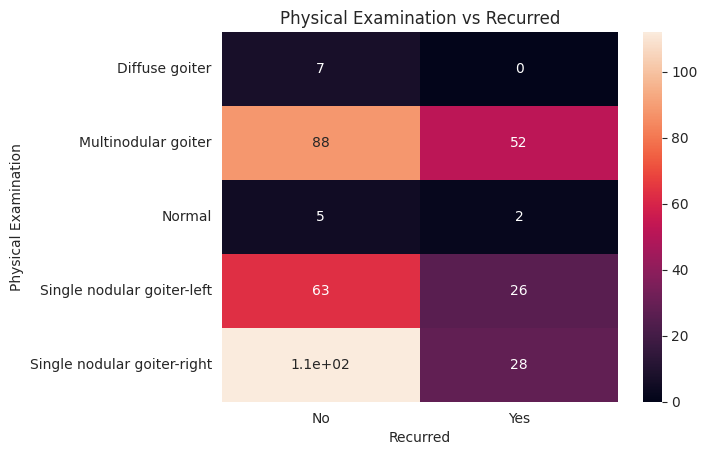

===== Physical Examination Chi2 Analysis =====
Chi2: 12.974379341840015
P-Value: 0.011401661887227106
Degrees of Freedom: 4
Expected Frequencies: [[  5.02610966   1.97389034]
 [100.52219321  39.47780679]
 [  5.02610966   1.97389034]
 [ 63.90339426  25.09660574]
 [100.52219321  39.47780679]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [37]:
contingency_heatmap_and_chi2("Physical Examination")

### Adenopathy Vs Recurred

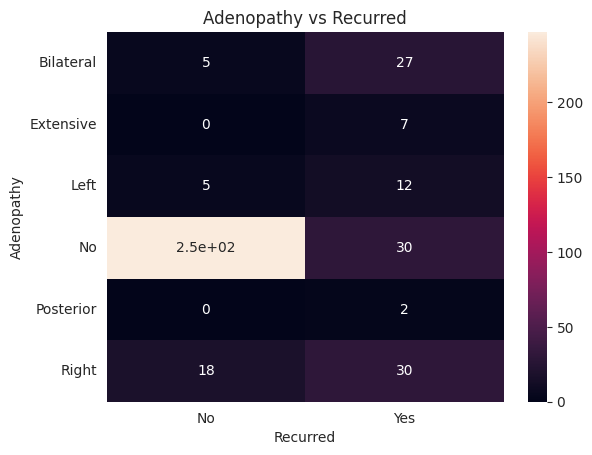

===== Adenopathy Chi2 Analysis =====
Chi2: 157.04429320211565
P-Value: 4.220720693153291e-32
Degrees of Freedom: 5
Expected Frequencies: [[ 22.97650131   9.02349869]
 [  5.02610966   1.97389034]
 [ 12.20626632   4.79373368]
 [198.89033943  78.10966057]
 [  1.43603133   0.56396867]
 [ 34.46475196  13.53524804]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [38]:
contingency_heatmap_and_chi2("Adenopathy")

### Pathology Vs Recurred

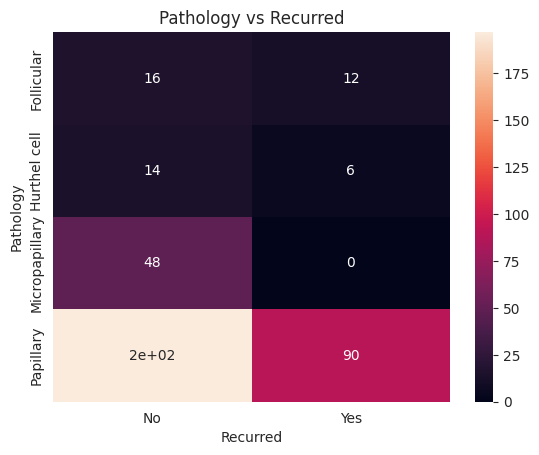

===== Pathology Chi2 Analysis =====
Chi2: 23.27043458980044
P-Value: 3.546645063731057e-05
Degrees of Freedom: 3
Expected Frequencies: [[ 20.10443864   7.89556136]
 [ 14.36031332   5.63968668]
 [ 34.46475196  13.53524804]
 [206.07049608  80.92950392]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [39]:
contingency_heatmap_and_chi2("Pathology")

### Focality Vs Recurrence

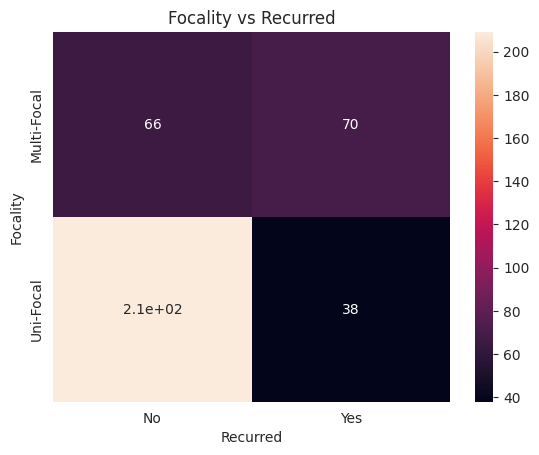

===== Focality Chi2 Analysis =====
Chi2: 54.641643458629716
P-Value: 1.4463803836917104e-13
Degrees of Freedom: 1
Expected Frequencies: [[ 97.65013055  38.34986945]
 [177.34986945  69.65013055]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [40]:
contingency_heatmap_and_chi2("Focality")

### Risk Vs Recurred

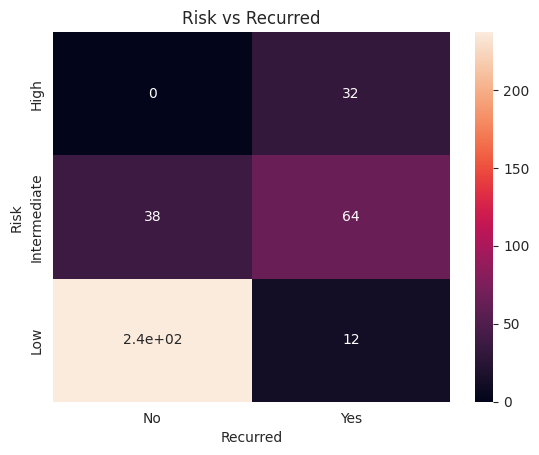

===== Risk Chi2 Analysis =====
Chi2: 208.82620309719766
P-Value: 4.50781577510179e-46
Degrees of Freedom: 2
Expected Frequencies: [[ 22.97650131   9.02349869]
 [ 73.23759791  28.76240209]
 [178.78590078  70.21409922]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [41]:
contingency_heatmap_and_chi2("Risk")

### T vs Recurred

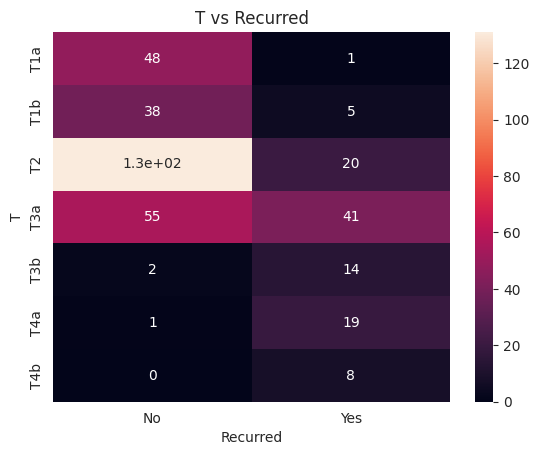

===== T Chi2 Analysis =====
Chi2: 141.29024573245127
P-Value: 5.353537306538777e-28
Degrees of Freedom: 6
Expected Frequencies: [[ 35.18276762  13.81723238]
 [ 30.87467363  12.12532637]
 [108.42036554  42.57963446]
 [ 68.92950392  27.07049608]
 [ 11.48825065   4.51174935]
 [ 14.36031332   5.63968668]
 [  5.74412533   2.25587467]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [42]:
contingency_heatmap_and_chi2("T")

### N vs Recurred

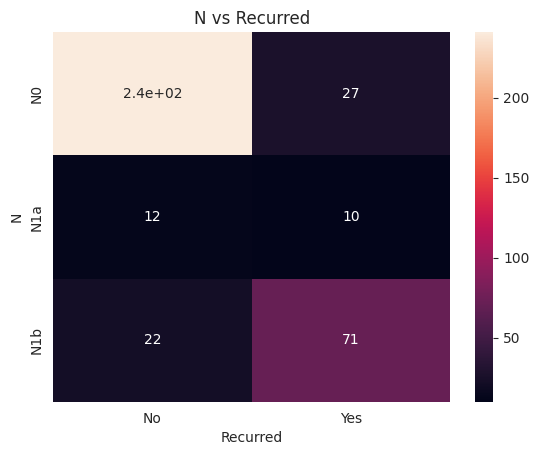

===== N Chi2 Analysis =====
Chi2: 153.1867635060231
P-Value: 5.443985431857947e-34
Degrees of Freedom: 2
Expected Frequencies: [[192.42819843  75.57180157]
 [ 15.79634465   6.20365535]
 [ 66.77545692  26.22454308]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [43]:
contingency_heatmap_and_chi2("N")

### M vs Recurred

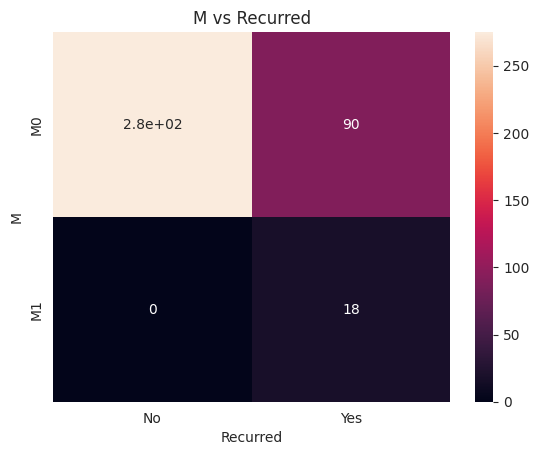

===== M Chi2 Analysis =====
Chi2: 44.44440560731619
P-Value: 2.616836848791985e-11
Degrees of Freedom: 1
Expected Frequencies: [[262.07571802 102.92428198]
 [ 12.92428198   5.07571802]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [44]:
contingency_heatmap_and_chi2("M")

### Stage vs Recurred

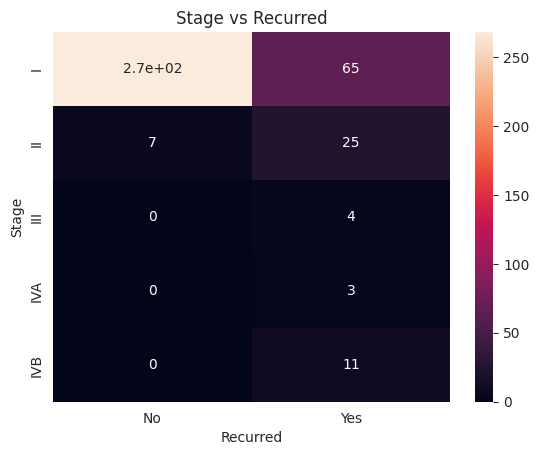

===== Stage Chi2 Analysis =====
Chi2: 97.61797139627001
P-Value: 3.1610731210091906e-20
Degrees of Freedom: 4
Expected Frequencies: [[239.09921671  93.90078329]
 [ 22.97650131   9.02349869]
 [  2.87206266   1.12793734]
 [  2.154047     0.845953  ]
 [  7.89817232   3.10182768]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [45]:
contingency_heatmap_and_chi2("Stage")

### Response vs Recurred

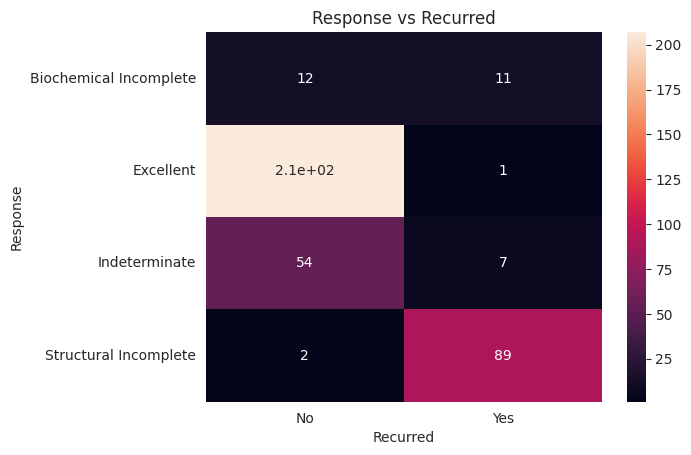

===== Response Chi2 Analysis =====
Chi2: 309.47232144451004
P-Value: 8.863123780463506e-67
Degrees of Freedom: 3
Expected Frequencies: [[ 16.51436031   6.48563969]
 [149.34725849  58.65274151]
 [ 43.79895561  17.20104439]
 [ 65.33942559  25.66057441]]
Reject Null Hypothesis, there is a difference in distribution of the feature with respect to the target variable.


In [46]:
contingency_heatmap_and_chi2("Response")

#### Code to create all contingency heatmaps and chi-squared analysis at once

```Python
cat_features = df.drop(['Recurred', 'Age'], axis=1)
columns = cat_features.columns

for col in columns:
    contingency_heatmap_and_chi2(col)
```

#### Conclusions

Only the Thyroid function columns seems to retain the null hypothesis. We will come back to $chi^2$ results when selecting features.

## 5. Multivariate Analysis

To evaluate multiple features, a correlation matrix will be utilised. To be able to do this, the categorical variables will need to be encoded to numerical values first. 

One of the things that must be considered when completing this is whether there is an order to the categories that are present within a feature. This tells us if One hot encoding or label encoding is most appropriate. One hot encoding is most appropriate when the labels are not ordinal (they do not have an order), whereas ordinal encoding is preferred for ordinal labels. Let's take a look at the categories for this dataset to decide.


In [47]:
# What are the categories in each feature
cat_features = df.drop(['Recurred', 'Age'], axis=1)
columns = cat_features.columns

for col in columns:
    print(f"Categories in {col}: {cat_features[col].unique()}")

Categories in Gender: ['F' 'M']
Categories in Smoking: ['No' 'Yes']
Categories in Hx Smoking: ['No' 'Yes']
Categories in Hx Radiothreapy: ['No' 'Yes']
Categories in Thyroid Function: ['Euthyroid' 'Clinical Hyperthyroidism' 'Clinical Hypothyroidism'
 'Subclinical Hyperthyroidism' 'Subclinical Hypothyroidism']
Categories in Physical Examination: ['Single nodular goiter-left' 'Multinodular goiter'
 'Single nodular goiter-right' 'Normal' 'Diffuse goiter']
Categories in Adenopathy: ['No' 'Right' 'Extensive' 'Left' 'Bilateral' 'Posterior']
Categories in Pathology: ['Micropapillary' 'Papillary' 'Follicular' 'Hurthel cell']
Categories in Focality: ['Uni-Focal' 'Multi-Focal']
Categories in Risk: ['Low' 'Intermediate' 'High']
Categories in T: ['T1a' 'T1b' 'T2' 'T3a' 'T3b' 'T4a' 'T4b']
Categories in N: ['N0' 'N1b' 'N1a']
Categories in M: ['M0' 'M1']
Categories in Stage: ['I' 'II' 'IVB' 'III' 'IVA']
Categories in Response: ['Indeterminate' 'Excellent' 'Structural Incomplete'
 'Biochemical Incomple

Regarding this dataset, it will not be appropriate to use one hot encoding for all categorical columns. As such, ordinal encoding will be applied to the columns related to staging and risk (NCI, 2015). One hot encoding will be applied to all other columns

In [72]:
# imports for encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [73]:
X = df.drop('Recurred', axis=1)

In [74]:
ohe_columns = ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Response']
oe_columns = ['Risk', 'T', 'N', 'M', 'Stage']
numeric_features = ['Age']


In [75]:
ohe = OneHotEncoder()
oe = OrdinalEncoder()

In [76]:
# Fit transform those columns
preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', ohe, ohe_columns),
        ('OrdinalEncoder', oe, oe_columns),
        ('numeric', 'passthrough', numeric_features)
    ]
)

In [77]:
df_transformed = preprocessor.fit_transform(df)

In [79]:
# View transformed columns
transformed_feature_names = (
    preprocessor.named_transformers_['OneHotEncoder'].get_feature_names_out(ohe_columns).tolist()
    + oe_columns
    + numeric_features
)
df_transformed = pd.DataFrame(df_transformed, columns=transformed_feature_names)

In [80]:
df_transformed.head()

,Gender_F,Gender_M,Smoking_No,Smoking_Yes,Hx Smoking_No,Hx Smoking_Yes,Hx Radiothreapy_No,Hx Radiothreapy_Yes,Thyroid Function_Clinical Hyperthyroidism,Thyroid Function_Clinical Hypothyroidism,...,Response_Biochemical Incomplete,Response_Excellent,Response_Indeterminate,Response_Structural Incomplete,Risk,T,N,M,Stage,Age
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,27.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,34.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,30.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,62.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,62.0


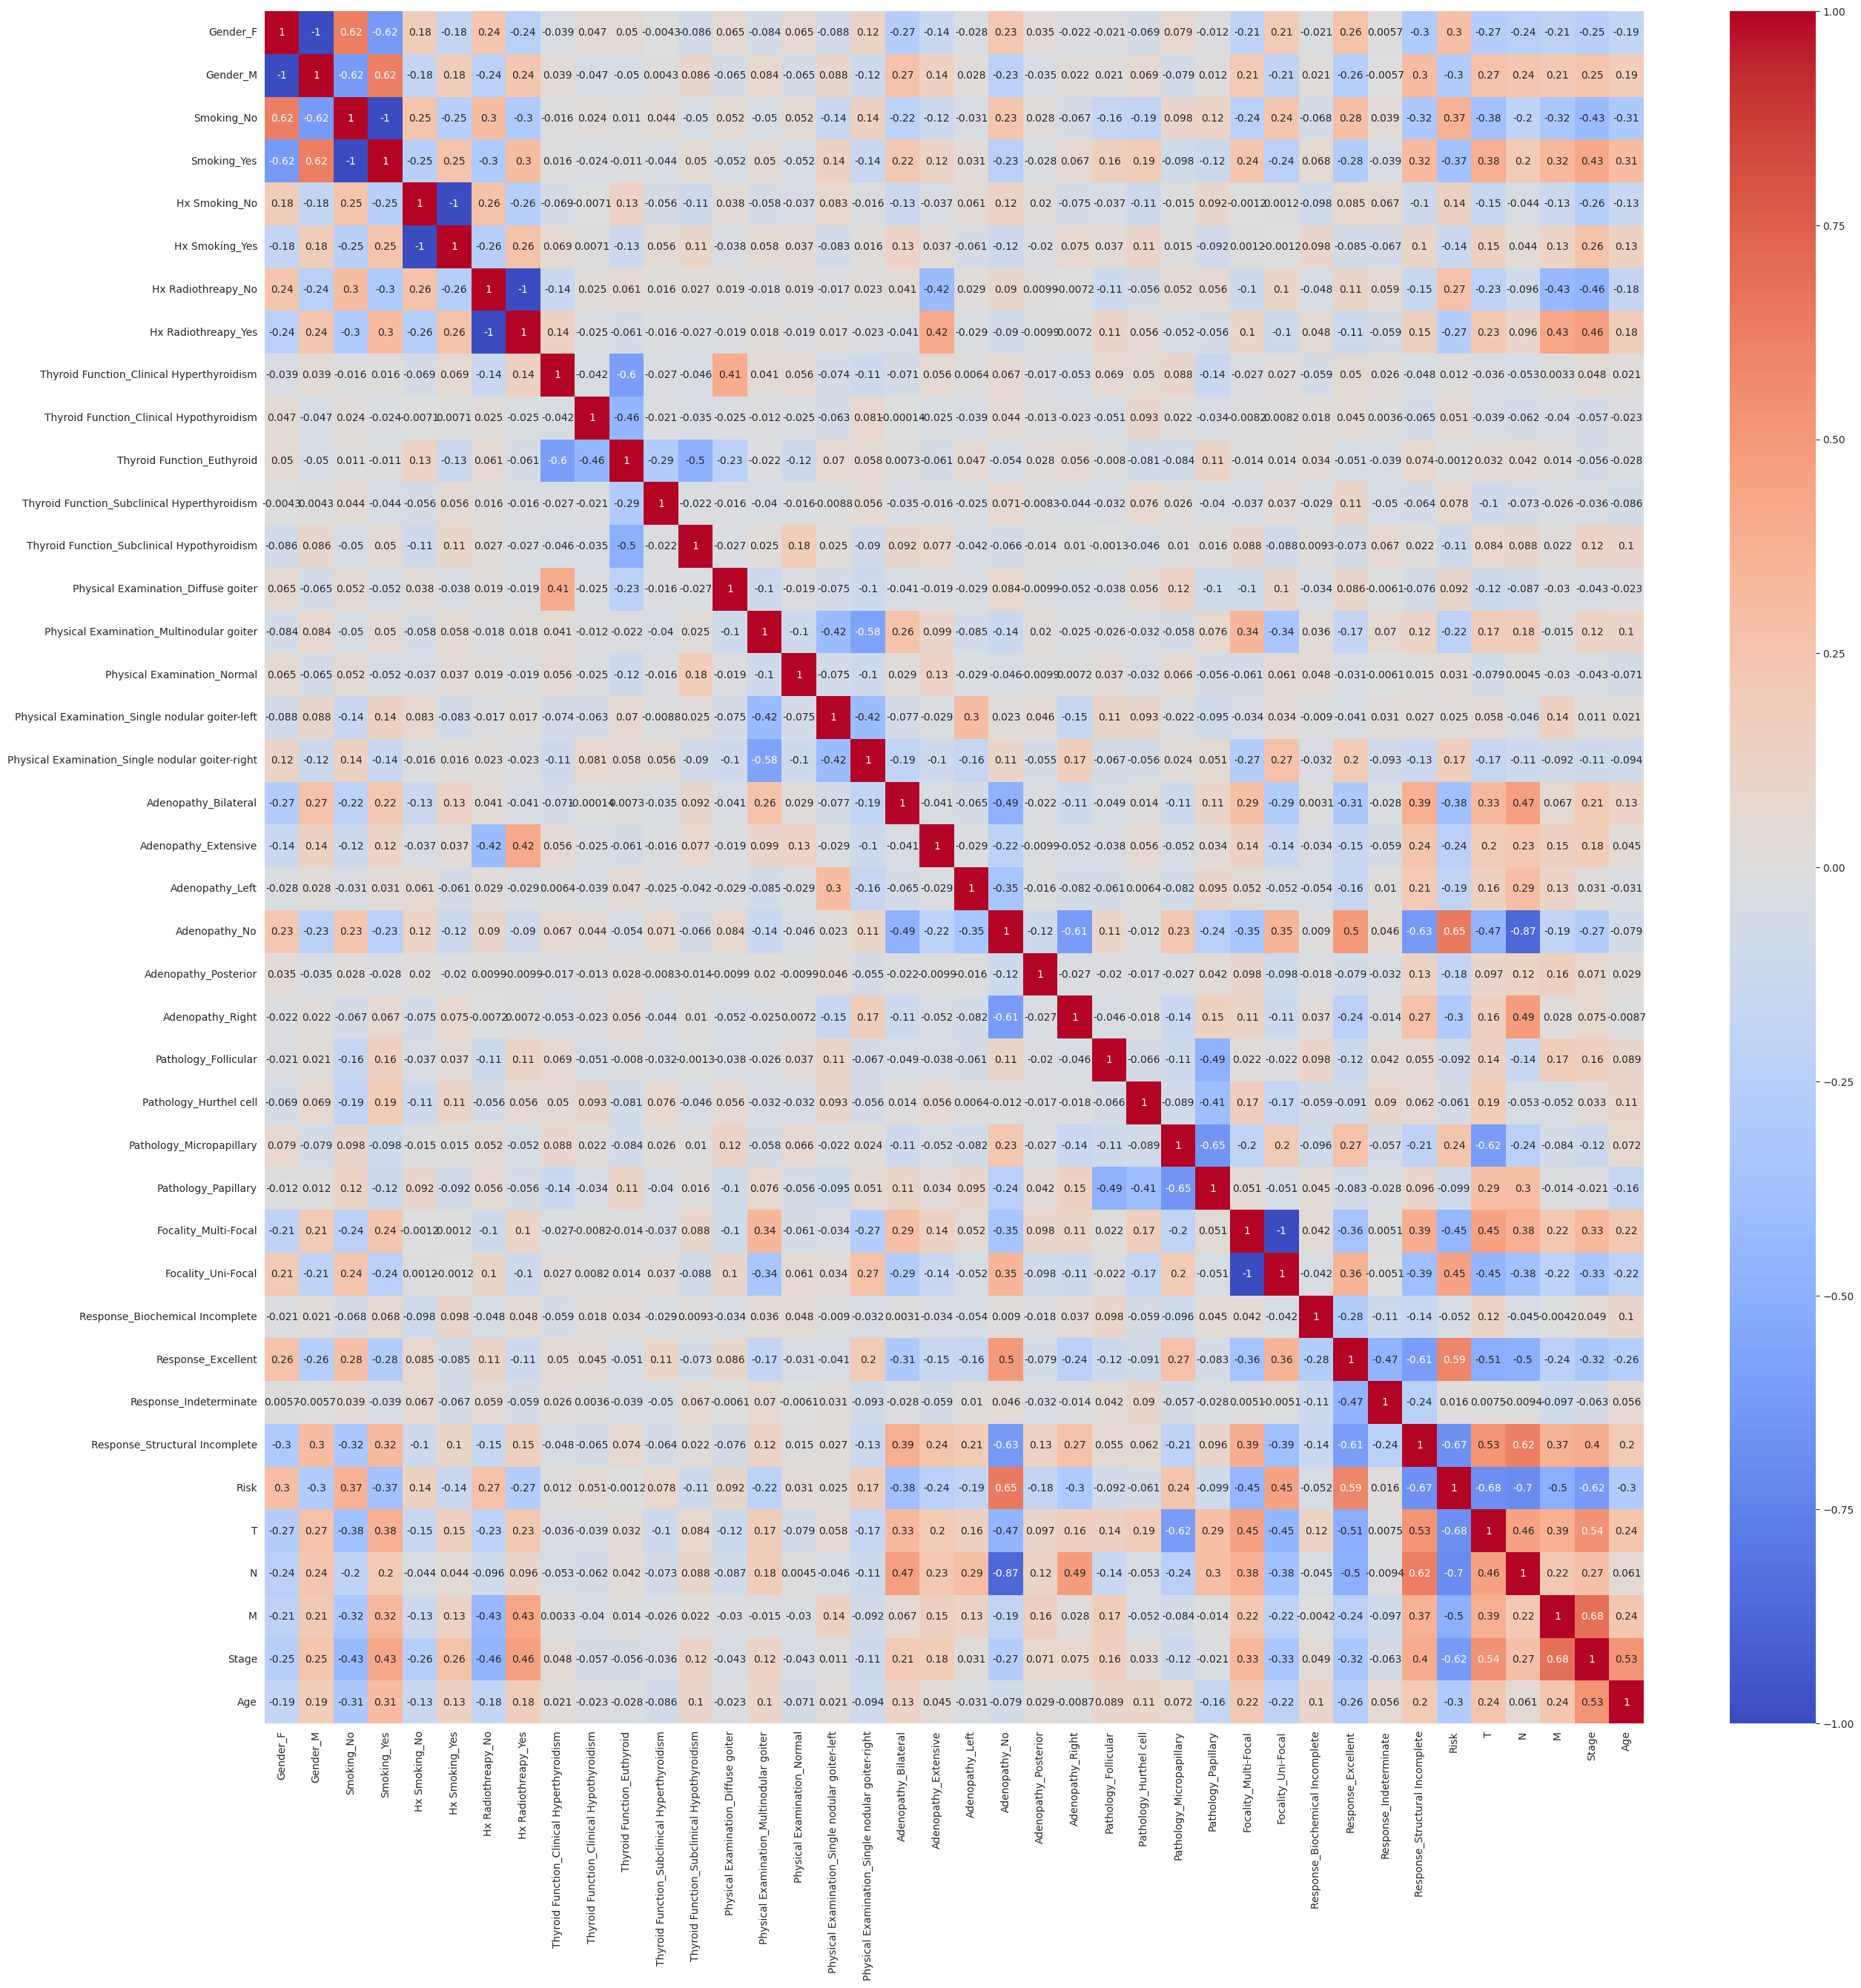

In [85]:
corr_matrix = df_transformed.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [90]:
# Saving transformed data
df_transformed.to_csv('../data/interim/category_transformed.csv', index=False)


#### References

- Cancer Staging - NCI [WWW Document], 2015. URL https://www.cancer.gov/about-cancer/diagnosis-staging/staging (accessed 7.20.24).
- Borzooei, S., Briganti, G., Golparian, M. et al. Machine learning for risk stratification of thyroid cancer patients: a 15-year cohort study. Eur Arch Otorhinolaryngol (2023). https://doi.org/10.1007/s00405-023-08299-w